In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy import interpolate
import math
import pickle
import classy 

matplotlib.rcParams['axes.linewidth'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.labelsize'] = 75
matplotlib.rcParams['xtick.labelsize'] = 65 
matplotlib.rcParams['ytick.labelsize'] = 65
matplotlib.rcParams['legend.fontsize'] = 150
matplotlib.rcParams['axes.labelpad'] = 100

In [2]:
!pip show classy

Name: classy
Version: 2.8.2
Summary: Python interface to the Cosmological Boltzmann code CLASS
Home-page: http://www.class-code.net
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /Users/alexreeves/Desktop/MastersThesis/masters-env/lib/python3.10/site-packages
Requires: 
Required-by: 


In [3]:
# fn_006 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_6/ede_mnu006.bestfit'
# fn_012 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_6/ede_mnu012.bestfit'
# fn_018 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_5/ede_mnu018.bestfit'
# fn_024 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_5/ede_mnu024.bestfit'
# fn_03 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_5/ede_mnu03.bestfit'

In [4]:
fn_006 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_006_Ivanov.bestfit'
fn_009 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_009_Ivanov.bestfit'
fn_012 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_012_Ivanov.bestfit'
fn_015 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_015_Ivanov.bestfit'
fn_018 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_018_Ivanov.bestfit'
fn_024 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_024_Ivanov.bestfit'
fn_03 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_03_Ivanov.bestfit'



In [5]:
fn_lcdm = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_29_minimize_al_LCDM_Ivanov.bestfit'

bfs_dict={}

In [6]:
#save the lcdm data in a dictionary 

with open(fn_lcdm) as f:
    bfs_dict['lcdm'] = {}
    for line in f: 
        if line.split()[0] == '#':
            print(len(line.split()))
            names = [line.split()[k].replace(',', '') for k in range(1,62)]
        else: 
            vals = line.split()

    print(len(names))
    print(len(vals))
    for j in range(len(vals)):
        bfs_dict['lcdm'][names[j]] = vals[j]


62
61
61


In [7]:
# fns = [fn_006,fn_012,fn_018,fn_024,fn_03]
# mnus= [6,12,18,24,30]

fns = [fn_006,fn_009,fn_012,fn_015,fn_018,fn_024,fn_03]
mnus= [6,9,12,15,18,24,30]


In [8]:
i=0
for fn in fns: 
    print(fn)
    with open(fn) as f:
        bfs_dict[f'{mnus[i]}'] = {}
        for line in f: 
            if line.split()[0] == '#':
                print(len(line.split()))
                names = [line.split()[k].replace(',', '') for k in range(1,65)]
            else: 
                vals = line.split()

        print(len(names))
        print(len(vals))
        for j in range(len(vals)):
            bfs_dict[f'{mnus[i]}'][names[j]] = vals[j]

    i+=1

/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_006_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_009_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_012_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_015_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_018_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_024_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_03_Ivanov.bestfit
65
64
64


In [9]:
print(classy.__file__)

/Users/alexreeves/Desktop/MastersThesis/masters-env/lib/python3.10/site-packages/classy.cpython-310-darwin.so


### In this notebook the position of the first BAO peak is compared for different $m_\nu$ models 

In [10]:
#function for loading in bestfit data 
def load_obj(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)
    

In [11]:
#be careful with scales- from param file only omega_b needs to be altered 
# mnu_006_dict= load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu006')
# mnu_012_dict=load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/ede_mnu012')
# mnu_018_dict=load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu018')
# mnu_024_dict = load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu024')
# mnu_03_dict= load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu03')

mnu_006_dict= bfs_dict['6']
mnu_012_dict= bfs_dict['12']
mnu_018_dict= bfs_dict['18']
mnu_024_dict= bfs_dict['24']
mnu_03_dict= bfs_dict['30']
mnu_015_dict= bfs_dict['15']
mnu_009_dict= bfs_dict['9']
lcdm_dict = bfs_dict['lcdm']

print(mnu_006_dict.keys())

dict_keys(['omega_b', 'omega_cdm', '100*theta_s', 'ln10^{10}A_s', 'n_s', 'tau_reio', 'fEDE', 'log10z_c', 'thetai_scf', 'A_cib_217', 'xi_sz_cib', 'A_sz', 'ps_A_100_100', 'ps_A_143_143', 'ps_A_143_217', 'ps_A_217_217', 'ksz_norm', 'gal545_A_100', 'gal545_A_143', 'gal545_A_143_217', 'gal545_A_217', 'galf_TE_A_100', 'galf_TE_A_100_143', 'galf_TE_A_100_217', 'galf_TE_A_143', 'galf_TE_A_143_217', 'galf_TE_A_217', 'calib_100T', 'calib_217T', 'A_planck', 'b^{(1)}_1', 'b^{(1)}_2', 'b^{(1)}_{G_2}', 'c^{(1)}_{0}', 'c^{(1)}_{2}', 'P^{(1)}_{shot}', 'b^{(1)}_4', 'b^{(2)}_1', 'b^{(2)}_2', 'b^{(2)}_{G_2}', 'c^{(2)}_{0}', 'c^{(2)}_{2}', 'P^{(2)}_{shot}', 'b^{(2)}_4', 'b^{(3)}_1', 'b^{(3)}_2', 'b^{(3)}_{G_2}', 'c^{(3)}_{0}', 'c^{(3)}_{2}', 'P^{(3)}_{shot}', 'b^{(3)}_4', 'b^{(4)}_1', 'b^{(4)}_2', 'b^{(4)}_{G_2}', 'c^{(4)}_{0}', 'c^{(4)}_{2}', 'P^{(4)}_{shot}', 'b^{(4)}_4', 'z_reio', 'Omega_m', 'YHe', 'H0', 'A_s', 'sigma8'])


In [12]:
#BEST FIT PARAMS FROM BF with LCDM model 
#TT,TE,EE +lowE -> switch to this + BAO 
LCDM_settings = {'output':'tCl pCl lCl mPk', 
                 '100*theta_s': lcdm_dict['100*theta_s'],
                 'ln10^{10}A_s': lcdm_dict['ln10^{10}A_s'],
                 'n_s': lcdm_dict['n_s'],
                 'omega_b':  float(lcdm_dict['omega_b']),
                 'omega_cdm': lcdm_dict['omega_cdm'],
                 'tau_reio': lcdm_dict['tau_reio'],
                 'l_max_scalars':3508,
                 'non linear':'HMcode',
                 'P_k_max_h/Mpc':30,
                 'Omega_Lambda':0,                      
                 'Omega_fld':0,                         
                 'Omega_scf': -1,                        #scf
                 'scf_parameters':'1, 1, 1, 1, 1, 0.0', #scf
                 'scf_tuning_index':3,                  #scf
                 'attractor_ic_scf':'no',               #scf
                 'n_scf':3,                             #scf
                 'CC_scf':1,                            #scf
                 'f_scf': np.power(10,26.59913),        #scf                              
                 'm_scf': 0,                            #scf: this guarantees fEDE is 0 (otherwise hard to force)
                 'thetai_scf': 2.83,        
                 'z_max_pk':2.}

In [13]:
LCDM = Class()
LCDM.set(LCDM_settings)
LCDM.compute()

print(LCDM.fEDE())

0.0


In [14]:
print(dir(LCDM))
print(LCDM.Omega_m())
print(LCDM.Omega0_m())
print(LCDM.Omega_Lambda())
print(LCDM.fEDE())

['Hubble', 'Neff', 'Om_m', 'Omega0_cdm', 'Omega0_k', 'Omega0_m', 'Omega_Lambda', 'Omega_b', 'Omega_g', 'Omega_m', 'Omega_nu', 'Omega_r', 'T_cmb', '__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '_check_task_dependency', '_fillparfile', '_pars_check', 'age', 'angular_distance', 'baryon_temperature', 'compute', 'density_cl', 'empty', 'fEDE', 'get_background', 'get_current_derived_parameters', 'get_fsigma8', 'get_perturbations', 'get_pk', 'get_pk_and_k_and_z', 'get_pk_array', 'get_pk_cb', 'get_pk_cb_array', 'get_pk_cb_lin', 'get_pk_lin', 'get_pk_mult', 'get_primordial', 'get_thermodynamics', 'get_transfer', 'h', 'initialize_output', 'ionization_fraction', 'lensed_cl', 'log10f_scf', 'log10m_scf

In [15]:
print(float(mnu_009_dict['omega_b']))

#Hmm this could be becuase it's not marginalised? 
#This is something to investigate -- would there be differences using the non-marginalised likelihood? 

0.02260485


In [16]:
EDE_fiducial_params= {'H0': 72.19,
         'log10z_c': 3.562,
         'thetai_scf': 2.83,
         'ln10^{10}A_s': np.log(22.15),
         'n_s': 0.9889,
         'omega_b': 0.0253,
         'omega_cdm': 0.12999,
         'tau_reio': 0.0511,
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.,
         'fEDE': 0.122}


EDE_pp_bf_params= {'100*theta_s': mnu_006_dict['100*theta_s'],
         'log10z_c': mnu_006_dict['log10z_c'],
         'thetai_scf': mnu_006_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_006_dict['ln10^{10}A_s'],
         'n_s': mnu_006_dict['n_s'],
         'omega_b':  float(mnu_006_dict['omega_b']),
         'omega_cdm': mnu_006_dict['omega_cdm'],
         'tau_reio': mnu_006_dict['tau_reio'],
         'fEDE': mnu_006_dict['fEDE'],
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.}


EDE_mnu_03_pp_bf_params= {'100*theta_s': mnu_03_dict['100*theta_s'],
         'log10z_c': mnu_03_dict['log10z_c'],
         'thetai_scf': mnu_03_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_03_dict['ln10^{10}A_s'],
         'n_s': mnu_03_dict['n_s'],
         'omega_b':  float(mnu_03_dict['omega_b']),
         'omega_cdm': mnu_03_dict['omega_cdm'],
         'tau_reio': mnu_03_dict['tau_reio'],
         'fEDE': mnu_03_dict['fEDE'],
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.3,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 


EDE_mnu_018_pp_bf_params= {'100*theta_s': mnu_018_dict['100*theta_s'],
         'log10z_c': mnu_018_dict['log10z_c'],
         'thetai_scf': mnu_018_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_018_dict['ln10^{10}A_s'],
         'n_s': mnu_018_dict['n_s'],
         'omega_b':  float(mnu_018_dict['omega_b']),
         'omega_cdm': mnu_018_dict['omega_cdm'],
         'tau_reio': mnu_018_dict['tau_reio'],
         'fEDE': mnu_018_dict['fEDE'],
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.18,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 


EDE_mnu_024_pp_bf_params= {'100*theta_s': mnu_024_dict['100*theta_s'],
         'log10z_c': mnu_024_dict['log10z_c'],
         'thetai_scf': mnu_024_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_024_dict['ln10^{10}A_s'],
         'n_s': mnu_024_dict['n_s'],
         'omega_b':  float(mnu_024_dict['omega_b']),
         'omega_cdm': mnu_024_dict['omega_cdm'],
         'tau_reio': mnu_024_dict['tau_reio'],
         'fEDE': mnu_024_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.24,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

EDE_mnu_015_pp_bf_params= {'100*theta_s': mnu_015_dict['100*theta_s'],
         'log10z_c': mnu_015_dict['log10z_c'],
         'thetai_scf': mnu_015_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_015_dict['ln10^{10}A_s'],
         'n_s': mnu_015_dict['n_s'],
         'omega_b':  float(mnu_015_dict['omega_b']),
         'omega_cdm': mnu_015_dict['omega_cdm'],
         'tau_reio': mnu_015_dict['tau_reio'],
         'fEDE': mnu_015_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.15,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

EDE_mnu_009_pp_bf_params= {'100*theta_s': mnu_009_dict['100*theta_s'],
         'log10z_c': mnu_009_dict['log10z_c'],
         'thetai_scf': mnu_009_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_009_dict['ln10^{10}A_s'],
         'n_s': mnu_009_dict['n_s'],
         'omega_b':  float(mnu_009_dict['omega_b']),
         'omega_cdm': mnu_009_dict['omega_cdm'],
         'tau_reio': mnu_009_dict['tau_reio'],
         'fEDE': mnu_009_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.09,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

EDE_mnu_012_pp_bf_params= {'100*theta_s': mnu_012_dict['100*theta_s'],
         'log10z_c': mnu_012_dict['log10z_c'],
         'thetai_scf': mnu_012_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_012_dict['ln10^{10}A_s'],
         'n_s': mnu_012_dict['n_s'],
         'omega_b':  float(mnu_012_dict['omega_b']),
         'omega_cdm': mnu_012_dict['omega_cdm'],
         'tau_reio': mnu_012_dict['tau_reio'],
         'fEDE': mnu_012_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.12,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

In [17]:
EDE_fid = Class()
EDE_fid.set(EDE_fiducial_params)
EDE_fid.compute()



In [18]:
EDE_pp = Class()
EDE_pp.set(EDE_pp_bf_params)
EDE_pp.compute()

In [19]:
EDE_mnu03 = Class()
EDE_mnu03.set(EDE_mnu_03_pp_bf_params)
EDE_mnu03.compute()


In [20]:
EDE_mnu018 = Class()
EDE_mnu018.set(EDE_mnu_018_pp_bf_params)
EDE_mnu018.compute()

In [21]:
EDE_mnu009 = Class()
EDE_mnu009.set(EDE_mnu_009_pp_bf_params)
EDE_mnu009.compute()

In [22]:
print(dir(EDE_mnu009))

['Hubble', 'Neff', 'Om_m', 'Omega0_cdm', 'Omega0_k', 'Omega0_m', 'Omega_Lambda', 'Omega_b', 'Omega_g', 'Omega_m', 'Omega_nu', 'Omega_r', 'T_cmb', '__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '_check_task_dependency', '_fillparfile', '_pars_check', 'age', 'angular_distance', 'baryon_temperature', 'compute', 'density_cl', 'empty', 'fEDE', 'get_background', 'get_current_derived_parameters', 'get_fsigma8', 'get_perturbations', 'get_pk', 'get_pk_and_k_and_z', 'get_pk_array', 'get_pk_cb', 'get_pk_cb_array', 'get_pk_cb_lin', 'get_pk_lin', 'get_pk_mult', 'get_primordial', 'get_thermodynamics', 'get_transfer', 'h', 'initialize_output', 'ionization_fraction', 'lensed_cl', 'log10f_scf', 'log10m_scf

In [23]:
print(EDE_mnu009.h())

0.6996044


In [24]:
EDE_mnu015 = Class()
EDE_mnu015.set(EDE_mnu_015_pp_bf_params)
EDE_mnu015.compute()

In [25]:
EDE_mnu024 = Class()
EDE_mnu024.set(EDE_mnu_024_pp_bf_params)
EDE_mnu024.compute()

In [26]:
EDE_mnu012 = Class()
EDE_mnu012.set(EDE_mnu_012_pp_bf_params)
EDE_mnu012.compute()

0.6996044


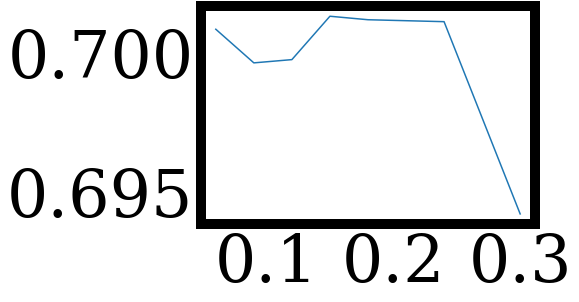

In [27]:
h_EDE_mnu03=EDE_mnu03.h()
h_EDE_mnu024 = EDE_mnu024.h()
h_EDE_mnu018 = EDE_mnu018.h()
h_EDE_mnu012 = EDE_mnu012.h()
h_EDE_mnu015 = EDE_mnu015.h()
h_EDE_mnu009 = EDE_mnu009.h()
h_EDE_pp = EDE_pp.h()

print(h_EDE_mnu009)
plt.plot([0.06,0.09, 0.12,0.15,0.18,0.24,0.3],[h_EDE_pp,h_EDE_mnu009, h_EDE_mnu012,h_EDE_mnu015,h_EDE_mnu018,h_EDE_mnu024,h_EDE_mnu03])


In [28]:
sig8_EDE_mnu03 = EDE_mnu03.sigma8()
sig8_EDE_mnu024 = EDE_mnu024.sigma8()
sig8_EDE_mnu018 = EDE_mnu018.sigma8()
sig8_EDE_mnu012 = EDE_mnu012.sigma8()
sig8_EDE_mnu015 = EDE_mnu015.sigma8()
sig8_EDE_mnu009 = EDE_mnu009.sigma8()
sig8_pp = EDE_pp.sigma8()

sig8_EDE_fid = EDE_fid.sigma8()
print(sig8_pp)
print(sig8_EDE_mnu009)
print(sig8_EDE_mnu012)
print(sig8_EDE_mnu015)
print(sig8_EDE_mnu018)
print(sig8_EDE_mnu024)
print(sig8_EDE_mnu03)


#COMAPRE WITH BENCHMARK LSS 3X2PT VALUE OF SIGMA8=0.733 FROM DES 

0.8282277953434376
0.8235279297309319
0.8197444401647173
0.8144886181601231
0.8114044428918482
0.8016058073288751
0.7874811615450962


In [29]:
rs_ede_fid = EDE_fid.rs_drag()
rs_lcdm = LCDM.rs_drag()
rs_ede_pp = EDE_pp.rs_drag()
rs_EDE_mnu03 = EDE_mnu03.rs_drag()
rs_EDE_mnu018 = EDE_mnu018.rs_drag()
rs_EDE_mnu024 = EDE_mnu024.rs_drag()
rs_EDE_mnu012 = EDE_mnu012.rs_drag()
rs_EDE_mnu015 = EDE_mnu015.rs_drag()
rs_EDE_mnu009 = EDE_mnu009.rs_drag()

print(rs_EDE_mnu03)
print(rs_EDE_mnu024)
print(rs_EDE_mnu018)
print(rs_EDE_mnu012)
print(rs_ede_pp)
print(rs_lcdm)
#MUCH SMALLER DECREASE IN R-S THAN EXPECTED! roughly 7% increase in ang diam distance and 5% reduction in r_s --- why s this and what values have we take for parameters! 

140.9667417447494
140.6084176303412
141.27559625865936
142.31745023581294
142.93651023333433
147.1725283888452


In [30]:
# #Get background quantities and recover their names:
baLCDM = LCDM.get_background()
baEDE_fid = EDE_fid.get_background()
baEDE_pp = EDE_pp.get_background()
baEDE_mnu03 = EDE_mnu03.get_background()
baEDE_mnu018 = EDE_mnu018.get_background()
baEDE_mnu024 = EDE_mnu024.get_background()
baEDE_mnu012 = EDE_mnu012.get_background()
baEDE_mnu009 = EDE_mnu009.get_background()
baEDE_mnu015 = EDE_mnu015.get_background()

EDE_pp_ang = baEDE_pp['ang.diam.dist.']
LCDM_ang = baLCDM['ang.diam.dist.']
EDE_mnu03_ang = baEDE_mnu03['ang.diam.dist.']
EDE_mnu018_ang = baEDE_mnu018['ang.diam.dist.']
EDE_mnu024_ang = baEDE_mnu024['ang.diam.dist.']
EDE_mnu012_ang = baEDE_mnu012['ang.diam.dist.']
EDE_mnu009_ang = baEDE_mnu009['ang.diam.dist.']
EDE_mnu015_ang = baEDE_mnu015['ang.diam.dist.']

z_lcdm = baLCDM['z']
z_ede_pp = baEDE_pp['z']
z_ede_mnu012 = baEDE_mnu012['z']
z_ede_mnu018 = baEDE_mnu018['z']
z_ede_mnu024 = baEDE_mnu024['z']
z_ede_mnu03 = baEDE_mnu03['z']
z_ede_mnu015 = baEDE_mnu015['z']
z_ede_mnu009 = baEDE_mnu009['z']

#Form the spherically averaged D_v  
#Made unitless as we look at ratios anyway 
LCDM_dv = ((((np.ones_like(z_lcdm)+z_lcdm)*LCDM_ang)**2)*z_lcdm/baLCDM['H [1/Mpc]'])**(1/3) 
EDE_pp_dv =((((np.ones_like(z_lcdm)+z_ede_pp)*EDE_pp_ang)**2)*z_ede_pp/baEDE_pp['H [1/Mpc]'])**(1/3)
EDE_mnu012_dv =((((np.ones_like(z_lcdm)+z_ede_mnu012)*EDE_mnu012_ang)**2)*z_ede_mnu012/baEDE_mnu012['H [1/Mpc]'])**(1/3)
EDE_mnu018_dv =((((np.ones_like(z_lcdm)+z_ede_mnu018)*EDE_mnu018_ang)**2)*z_ede_mnu018/baEDE_mnu018['H [1/Mpc]'])**(1/3)
EDE_mnu024_dv =((((np.ones_like(z_lcdm)+z_ede_mnu024)*EDE_mnu024_ang)**2)*z_ede_mnu024/baEDE_mnu024['H [1/Mpc]'])**(1/3)
EDE_mnu03_dv =((((np.ones_like(z_lcdm)+z_ede_mnu03)*EDE_mnu03_ang)**2)*z_ede_mnu03/baEDE_mnu03['H [1/Mpc]'])**(1/3)
EDE_mnu009_dv =((((np.ones_like(z_lcdm)+z_ede_mnu009)*EDE_mnu009_ang)**2)*z_ede_mnu009/baEDE_mnu009['H [1/Mpc]'])**(1/3)
EDE_mnu015_dv =((((np.ones_like(z_lcdm)+z_ede_mnu015)*EDE_mnu015_ang)**2)*z_ede_mnu03/baEDE_mnu015['H [1/Mpc]'])**(1/3)



EDE_pp_ratios = EDE_pp_dv/rs_ede_pp
LCDM_ratios = LCDM_dv/rs_lcdm
EDE_mnu03_ratios = EDE_mnu03_dv/rs_EDE_mnu03
EDE_mnu018_ratios = EDE_mnu018_dv/rs_EDE_mnu018
EDE_mnu024_ratios = EDE_mnu024_dv/rs_EDE_mnu024
EDE_mnu012_ratios = EDE_mnu012_dv/rs_EDE_mnu012
EDE_mnu015_ratios = EDE_mnu015_dv/rs_EDE_mnu015
EDE_mnu009_ratios = EDE_mnu009_dv/rs_EDE_mnu009

#erroneous analysis without spherically averaged distances 
# EDE_pp_ratios = EDE_pp_ang/rs_ede_pp
# LCDM_ratios = LCDM_ang/rs_lcdm
# EDE_mnu03_ratios = EDE_mnu03_ang/rs_EDE_mnu03
# EDE_mnu018_ratios = EDE_mnu018_ang/rs_EDE_mnu018
# EDE_mnu024_ratios = EDE_mnu024_ang/rs_EDE_mnu024
# EDE_mnu012_ratios = EDE_mnu012_ang/rs_EDE_mnu012

In [31]:
#making an interpolation to match up the z values for different experiments 

EDE_pp_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_pp),np.flip(EDE_pp_ratios))
EDE_mnu012_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu012),np.flip(EDE_mnu012_ratios))
EDE_mnu018_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu018),np.flip(EDE_mnu018_ratios))
EDE_mnu024_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu024),np.flip(EDE_mnu024_ratios))
EDE_mnu03_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu03),np.flip(EDE_mnu03_ratios))
EDE_mnu009_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu009),np.flip(EDE_mnu009_ratios))
EDE_mnu015_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu015),np.flip(EDE_mnu015_ratios))

In [32]:
EDE_pp_out = EDE_pp_spline(z_lcdm)
EDE_mnu012_out = EDE_mnu012_spline(z_lcdm)
EDE_mnu018_out = EDE_mnu018_spline(z_lcdm)
EDE_mnu024_out = EDE_mnu024_spline(z_lcdm)
EDE_mnu03_out = EDE_mnu03_spline(z_lcdm)
EDE_mnu009_out = EDE_mnu009_spline(z_lcdm)
EDE_mnu015_out = EDE_mnu015_spline(z_lcdm)

## Make interesting d_a plot/r_s -- I think this will be fixed at recombination 

/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_22579/3575929716.py:14: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_pp_out*rs_lcdm/(LCDM_dv), label='mnu006')
/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_22579/3575929716.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_mnu012_out*rs_lcdm/(LCDM_dv),label='mnu012')
/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_22579/3575929716.py:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_mnu018_out*rs_lcdm/(LCDM_dv),label='mnu018')
/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_22579/3575929716.py:17: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_mnu024_out*rs_lcdm/(LCDM_dv),label='mnu024')
/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_22579/3575929716.py:18: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, ED

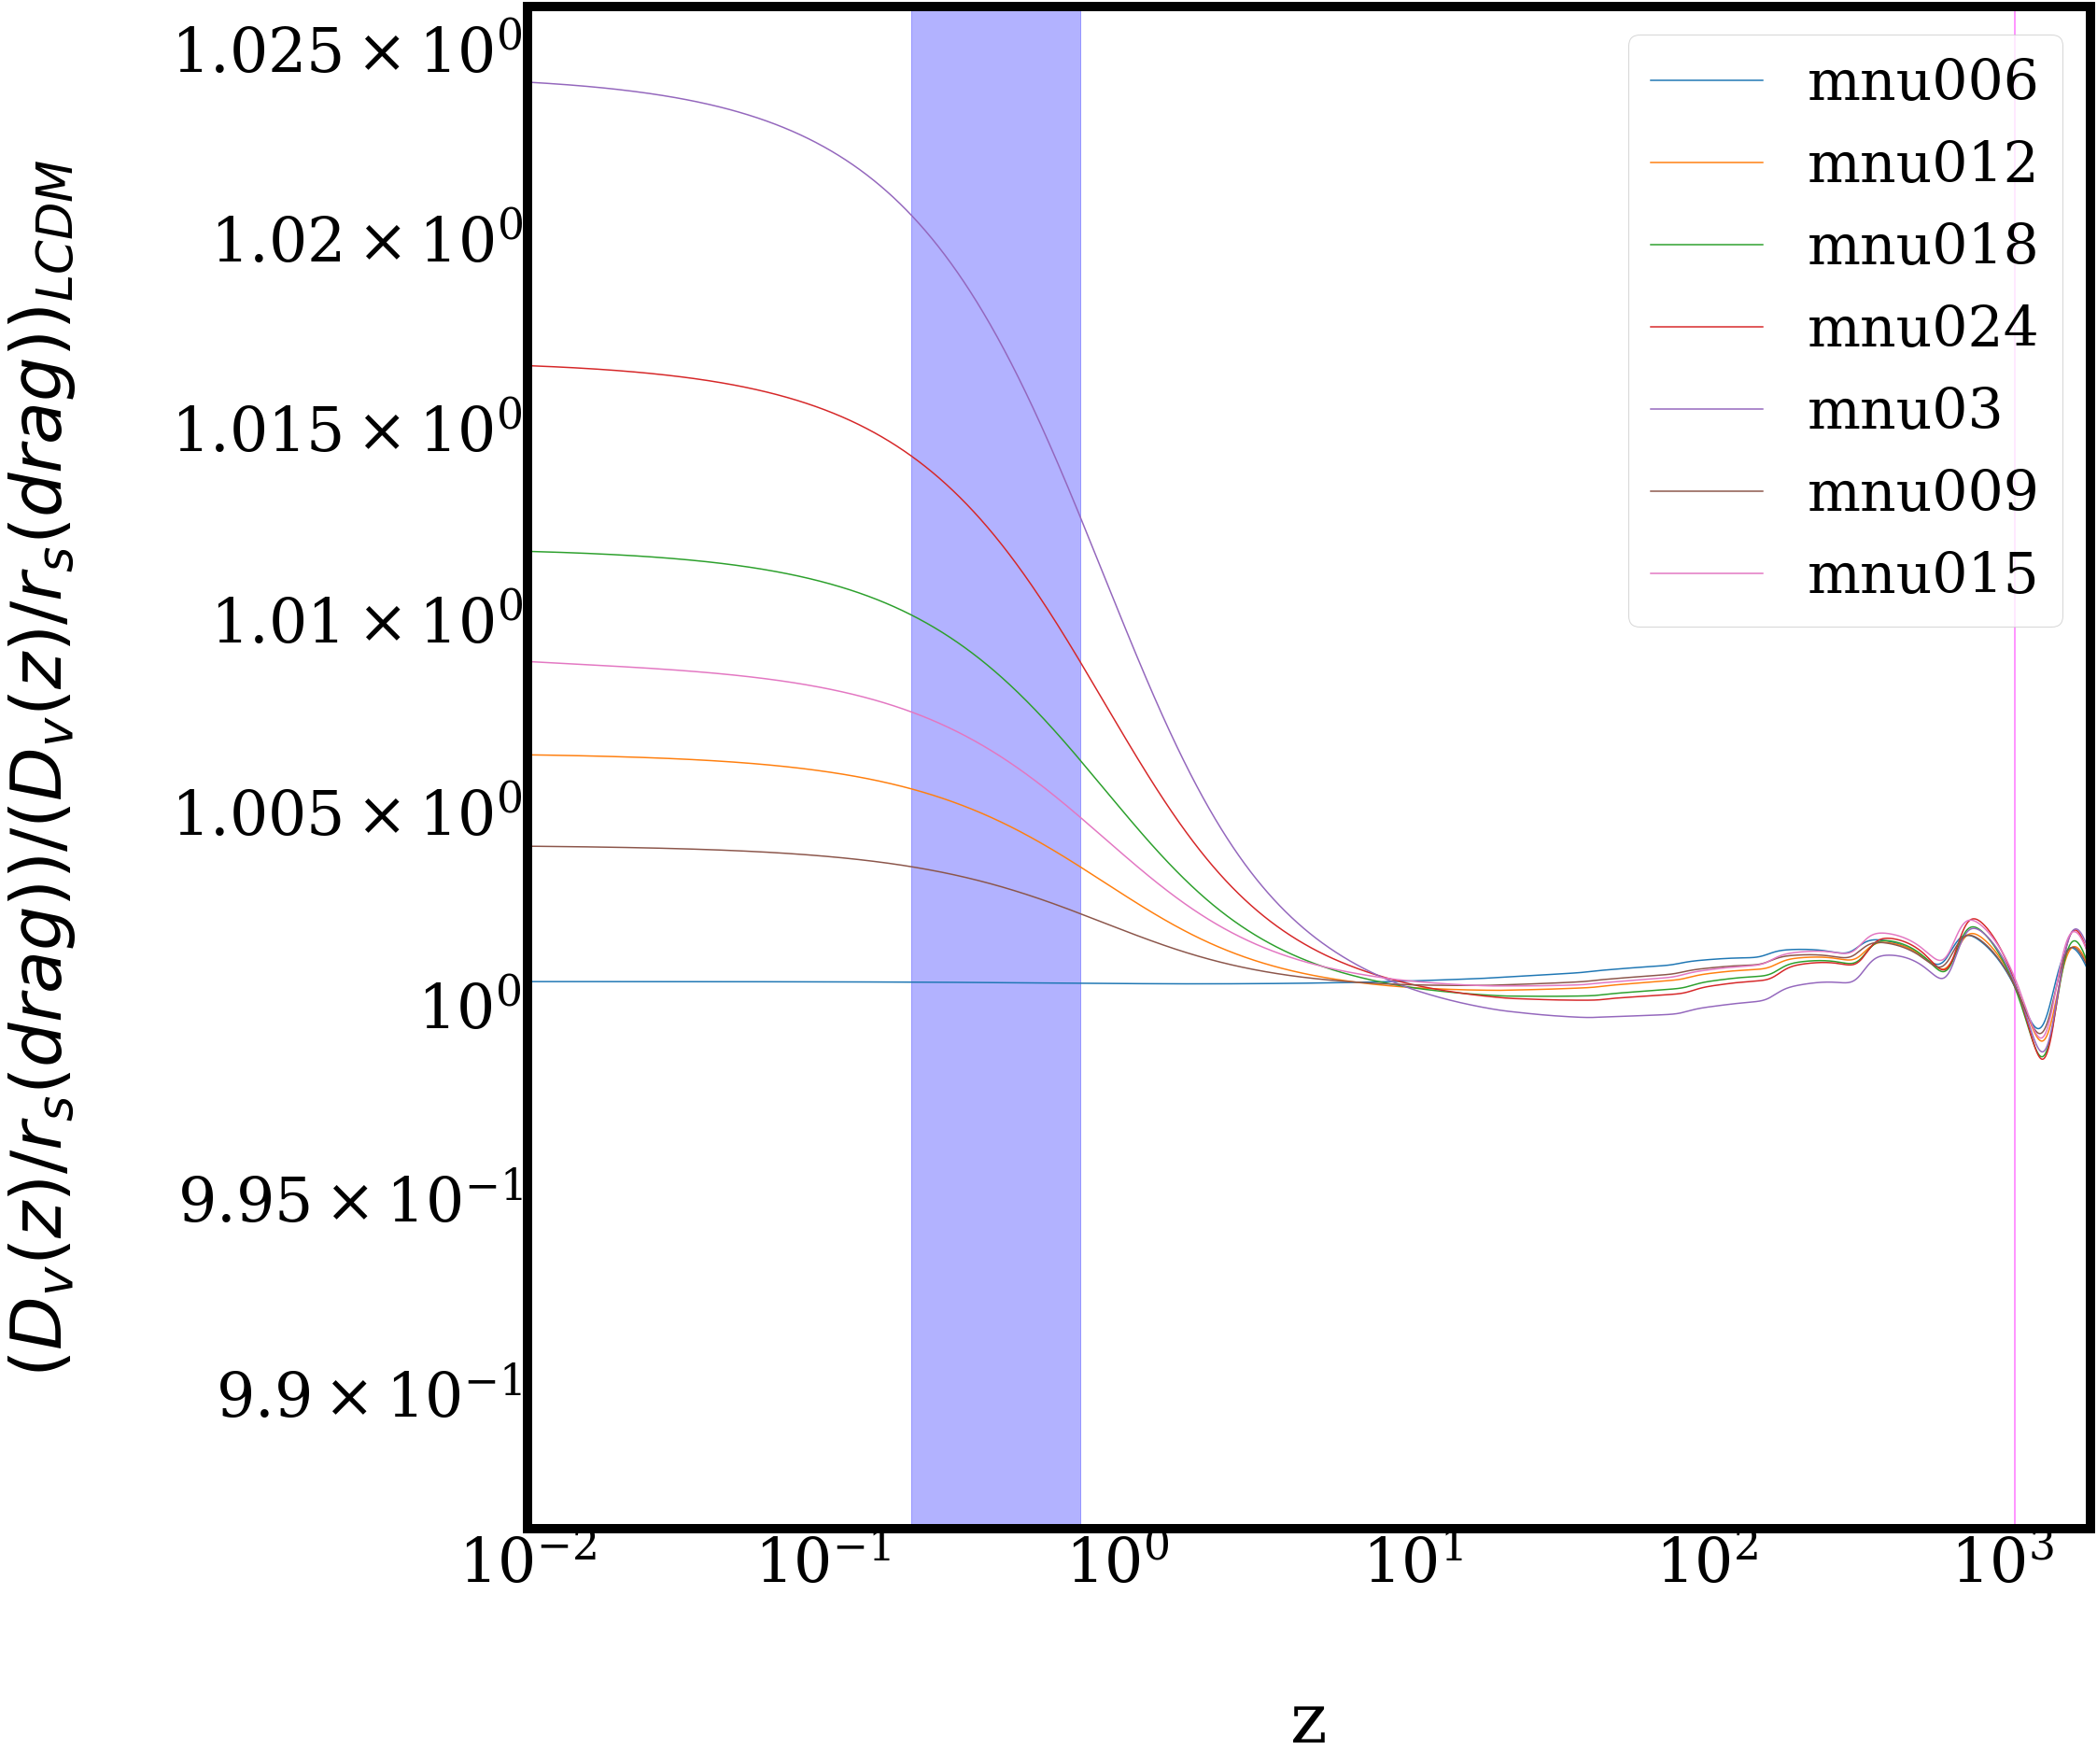

In [33]:
fig, ax = plt.subplots(figsize=(30,30))

matplotlib.rcParams['legend.fontsize'] = 60

# ax.loglog(z_lcdm, LCDM_ang, 'r')
# ax.loglog(z_lcdm, EDE_pp_out*rs_ede_pp/LCDM_dv, label='mnu006')
# ax.loglog(z_lcdm, EDE_mnu012_out*rs_EDE_mnu012/LCDM_dv,label='mnu012')
# ax.loglog(z_lcdm, EDE_mnu018_out*rs_EDE_mnu018/LCDM_dv,label='mnu018')
# ax.loglog(z_lcdm, EDE_mnu024_out*rs_EDE_mnu024/LCDM_dv,label='mnu024')
# ax.loglog(z_lcdm, EDE_mnu03_out*rs_EDE_mnu03/LCDM_dv, label='mnu03')
# ax.loglog(z_lcdm, EDE_mnu009_out*rs_EDE_mnu009/LCDM_dv, label='mnu009')
# ax.loglog(z_lcdm, EDE_mnu015_out*rs_EDE_mnu015/LCDM_dv, label='mnu015')

ax.loglog(z_lcdm, EDE_pp_out*rs_lcdm/(LCDM_dv), label='mnu006')
ax.loglog(z_lcdm, EDE_mnu012_out*rs_lcdm/(LCDM_dv),label='mnu012')
ax.loglog(z_lcdm, EDE_mnu018_out*rs_lcdm/(LCDM_dv),label='mnu018')
ax.loglog(z_lcdm, EDE_mnu024_out*rs_lcdm/(LCDM_dv),label='mnu024')
ax.loglog(z_lcdm, EDE_mnu03_out*rs_lcdm/(LCDM_dv), label='mnu03')
ax.loglog(z_lcdm, EDE_mnu009_out*rs_lcdm/(LCDM_dv), label='mnu009')
ax.loglog(z_lcdm, EDE_mnu015_out*rs_lcdm/(LCDM_dv), label='mnu015')

ax.set_xlim(0.01,2000)
plt.legend()

ax.axvspan(0.2, 0.75, alpha=0.3, color='blue')

ax.axvspan(1100, 1110, alpha=0.3, color='magenta')


ax.set_xlabel('z')
ax.set_ylabel(r'$(D_v(z)/r_{s}(drag))/(D_v(z)/r_{s}(drag))_{LCDM}$')

fig.savefig('d_a_evolution.pdf', bbox_inches='tight')

In [60]:
#THE BOSS DATA POINTS: 

rd_fid = 147.78 #MPc (fiducial r_d value used in paper)

boss_zs = [0.38,0.51,0.61] #the average redshifts at which the BOSS data is collected 

boss_vals = np.array([1477,1877,2140]) #The average values of D_v * rd_fid/r_d from the BOSS data section 8.2 eqts 21-23 in https://arxiv.org/pdf/1607.03155.pdf

boss_vals = boss_vals/rd_fid

z_038 = np.where((z_lcdm<=0.38) & (z_lcdm>=0.379))[0][0]

z_051 = np.where((z_lcdm<=0.51) & (z_lcdm>=0.509))[0][0]

z_061 = np.where((z_lcdm<=0.61) & (z_lcdm>=0.609))[0][0]

lcdm_reference_vals = np.array([LCDM_ratios[z_038], LCDM_ratios[z_051], LCDM_ratios[z_061]])
boss_ratios = boss_vals/lcdm_reference_vals

print(boss_ratios)

[1.00375075 0.99720699 0.98836493]


In [61]:
zs = z_lcdm[(z_lcdm >= 0.1) & (z_lcdm <= 1)]


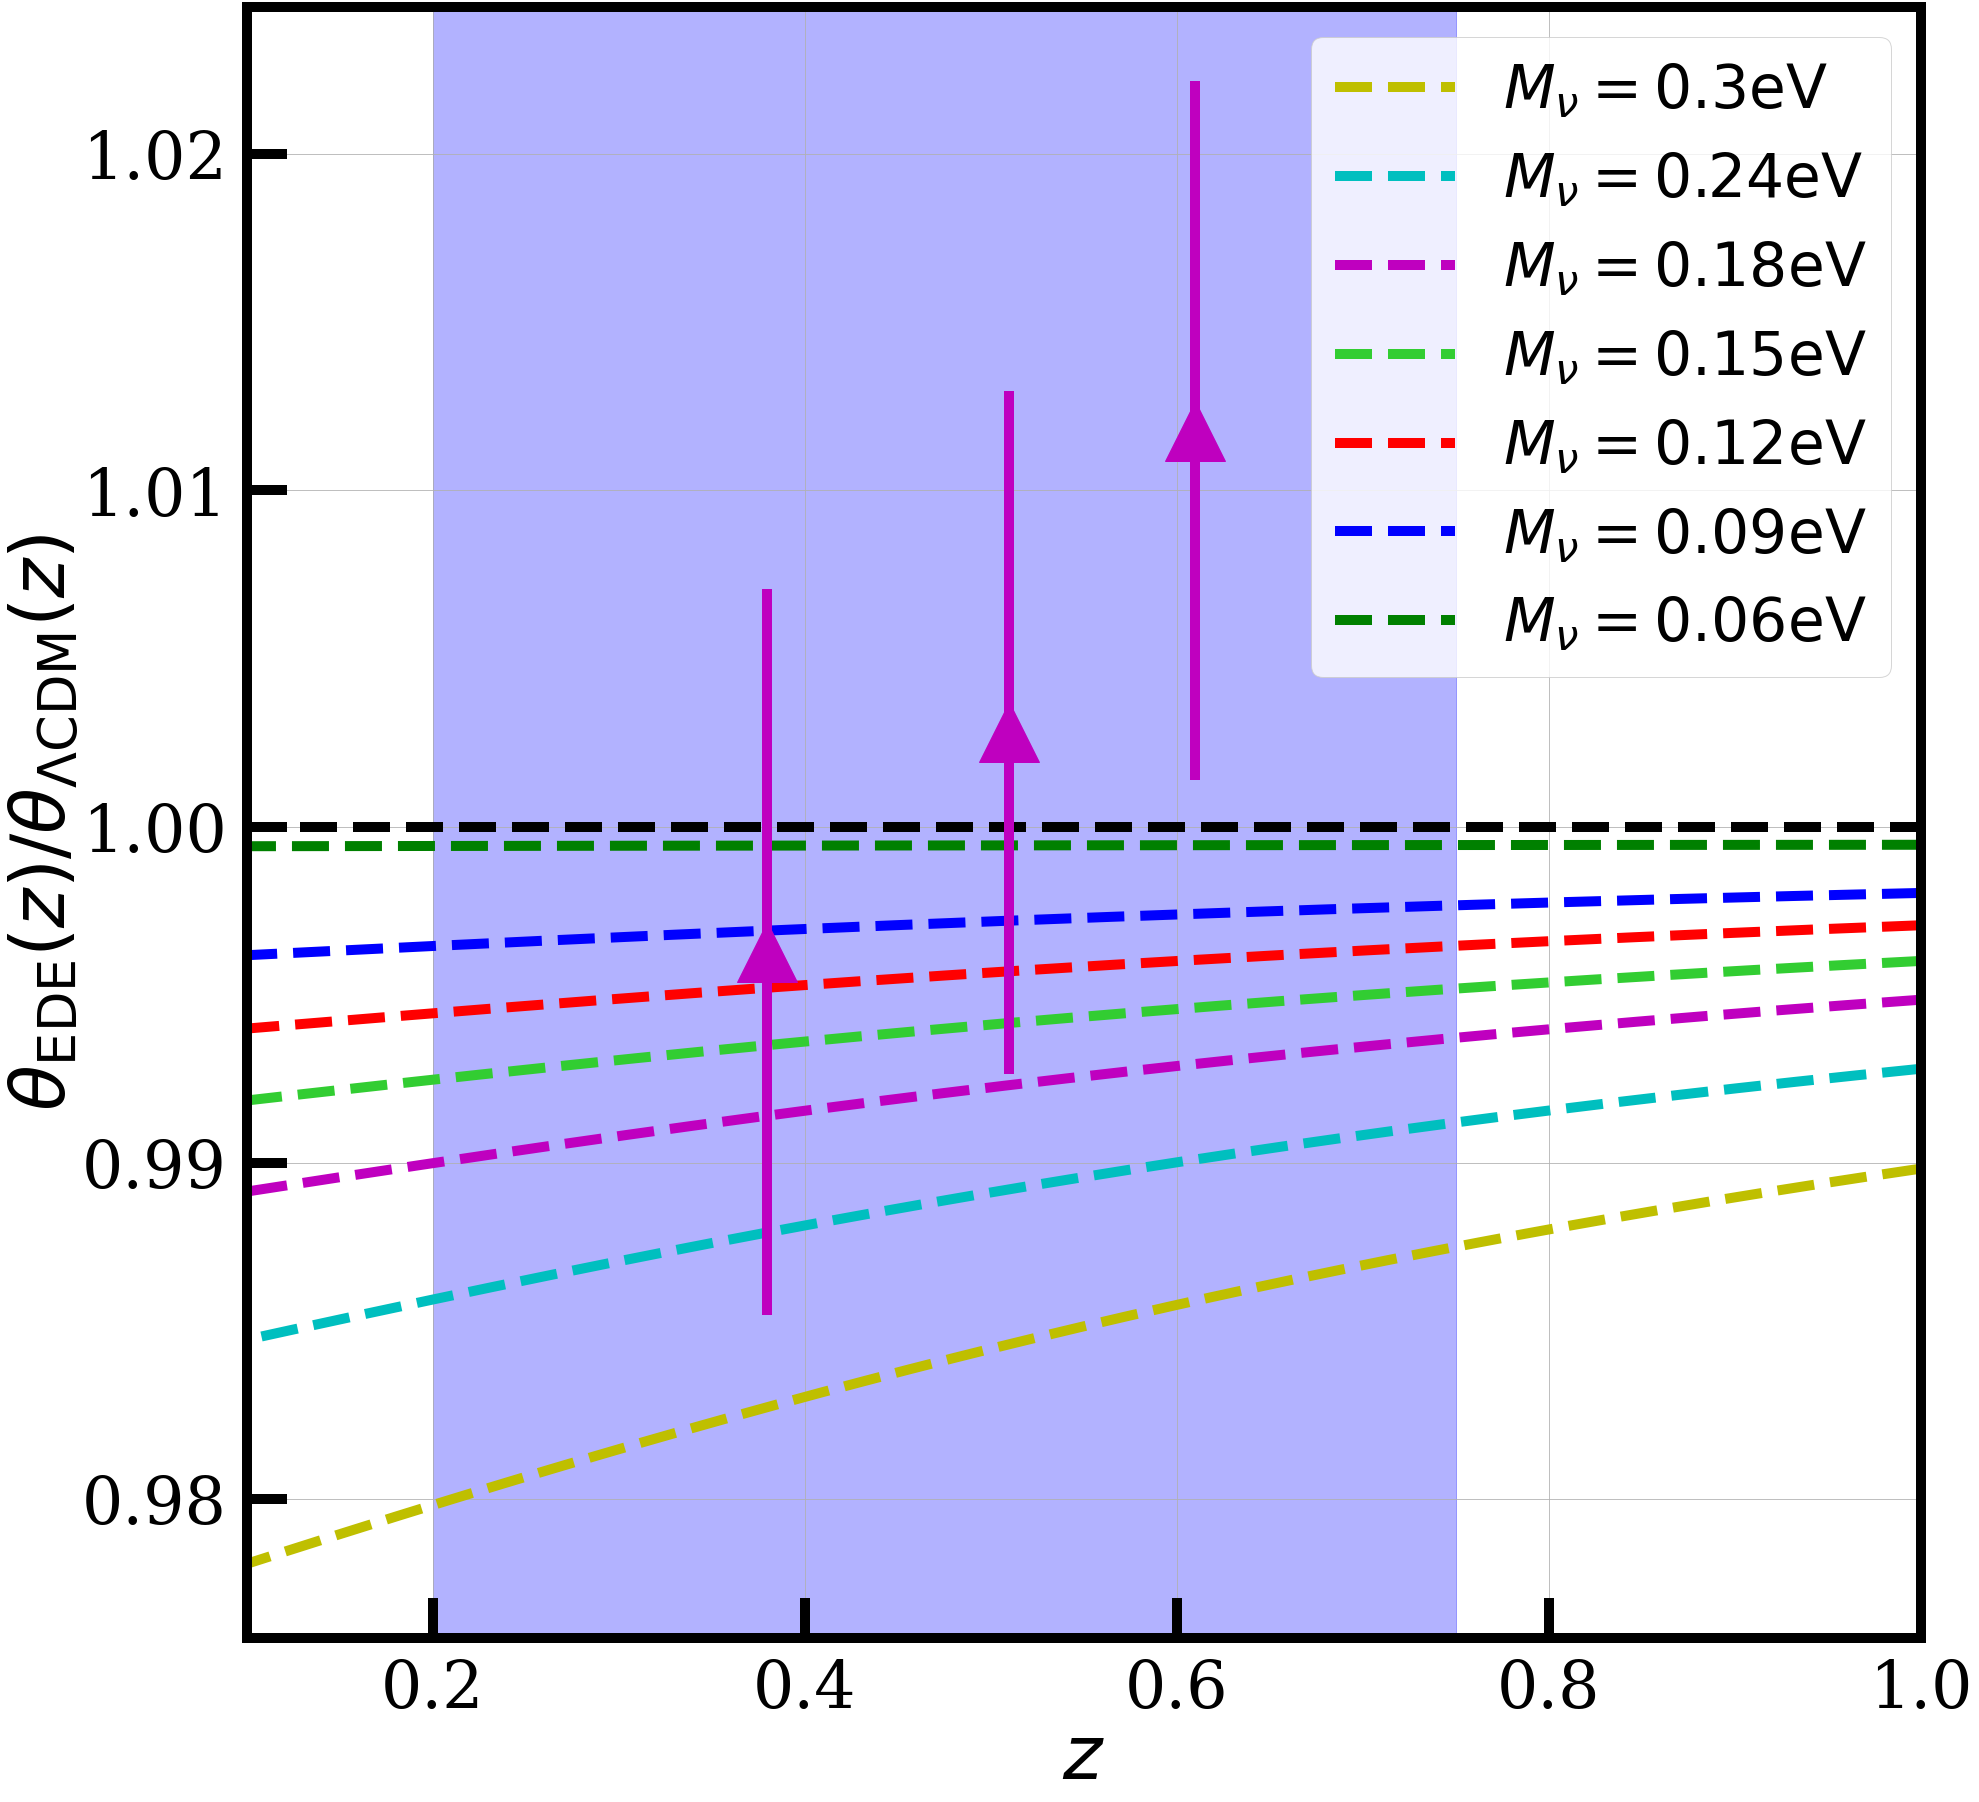

In [64]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
matplotlib.rcParams['legend.fontsize'] = 60
matplotlib.rcParams['axes.labelpad'] = 0

#take out the third BOSS redshift 

fig, ax1 = plt.subplots(1, 1,figsize=(30,30))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


ax1.grid()
# ax1.plot(zs,LCDM_ratios,c='k', lw=50,label=r'$\Lambda$CDM')
# ax1.plot(zs,EDE_fid_ratios/LCDM_ratios ,color= 'b',ls='--',lw=30,label= 'EDE fiducial from CH (m_nu = 0.06eV)')
# ax1.plot(zs,EDE_mnu03_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'y',ls='--',lw=10,label=  r'$M_\nu=0.3\rm eV$')
# ax1.plot(zs,EDE_mnu024_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'c',ls='--',lw=10,label=  r'$M_\nu=0.24 \rm eV$')
# ax1.plot(zs,EDE_mnu018_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'm',ls='--',lw=10,label=  r'$M_\nu=0.18 \rm eV$')
# ax1.plot(zs,EDE_mnu015_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'limegreen',ls='--',lw=10,label=  r'$M_\nu=0.15 \rm eV$')
# ax1.plot(zs,EDE_mnu012_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'r',ls='--',lw=10,label=  r'$M_\nu=\rm 0.12eV$')
# ax1.plot(zs,EDE_mnu009_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'b',ls='--',lw=10,label=  r'$M_\nu= \rm 0.09eV$')
# ax1.plot(zs,EDE_pp_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'g',ls='--',lw=10,label= r'$M_\nu= \rm 0.06eV$')

ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu03_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'y',ls='--',lw=10,label=  r'$M_\nu=0.3\rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu024_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)],color= 'c',ls='--',lw=10,label=  r'$M_\nu=0.24 \rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu018_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'm',ls='--',lw=10,label=  r'$M_\nu=0.18 \rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu015_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'limegreen',ls='--',lw=10,label=  r'$M_\nu=0.15 \rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu012_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'r',ls='--',lw=10,label=  r'$M_\nu=\rm 0.12eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu009_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'b',ls='--',lw=10,label=  r'$M_\nu= \rm 0.09eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_pp_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)],color= 'g',ls='--',lw=10,label= r'$M_\nu= \rm 0.06eV$')

ax1.axhline(1,c='k',lw=10,ls='--')
# yerr= np.array([(16/rd_fid),(19/rd_fid),(22/rd_fid)])/lcdm_reference_vals #from the error in the alam paper: https://arxiv.org/pdf/1607.03155.pdf eqts 21-23 in sect. 8.2 consensus BAO + fs results
boss_fractional_err = np.array([(16/rd_fid),(19/rd_fid),(22/rd_fid)])/boss_vals #from the error in the alam paper: https://arxiv.org/pdf/1607.03155.pdf eqts 21-23 in sect. 8.2 consensus BAO + fs results
boss_err = boss_fractional_err * boss_vals**(-1) * lcdm_reference_vals #assume the fractional error in the value of theta is the same as in the value of 1/theta

ax1.errorbar(boss_zs, (boss_ratios)**(-1), yerr=boss_err, fmt='^', color='m', markersize=60, capthick=40,lw=10)
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\theta_{\rm EDE}(z)/\theta_{\Lambda{\rm CDM}}(z)$')
# ax1.set_ylim(0.98,1.05)
ax1.set_xlim(0.1,1.0)

ax1.tick_params(pad=20)
ax1.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax1.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax1.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax1.tick_params(which='minor',axis='y', length=25, width=5, direction='in')
ax1.legend(loc='best')

#ADD BOSS DR12 AND OTHER DATA (commented out) 

#Decrease the width of lines 
#Span the whole 

ax1.axvspan(0.2, 0.75, alpha=0.3, color='blue')
fig.savefig('BAO_postion_plot.png', bbox_inches='tight')


## Let's look at the trends in the bestfit values 

In [ ]:
def trend_plot(param): 
    param_list=[]
    dict_list = [mnu_006_dict, mnu_012_dict,mnu_018_dict ,mnu_024_dict ,mnu_03_dict]
    for dictionary in dict_list:
        param_list.append(float(dictionary[param]))
        
    fig, ax = plt.subplots(figsize=(30,30))
    x_axis = np.array([0.06,0.12,0.18,0.24,0.30])
    print(param_list)
    ax.plot(x_axis, param_list)
        
        
    ax.set_xlabel(r'$m_\nu$(eV)')
    ax.set_ylabel(param)
    

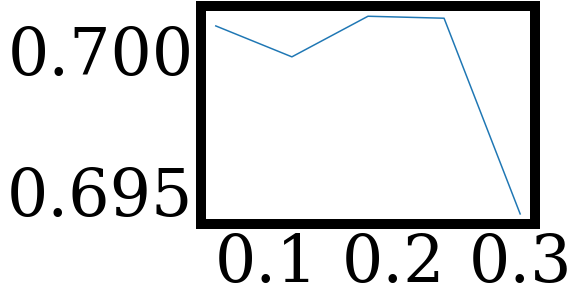

In [ ]:
h_EDE_mnu03=EDE_mnu03.h()
h_EDE_mnu024 = EDE_mnu024.h()
h_EDE_mnu018 = EDE_mnu018.h()
h_EDE_mnu012 = EDE_mnu012.h()
h_EDE_pp = EDE_pp.h()

plt.plot([0.06,0.12,0.18,0.24,0.3],[h_EDE_pp,h_EDE_mnu012,h_EDE_mnu018,h_EDE_mnu024,h_EDE_mnu03])


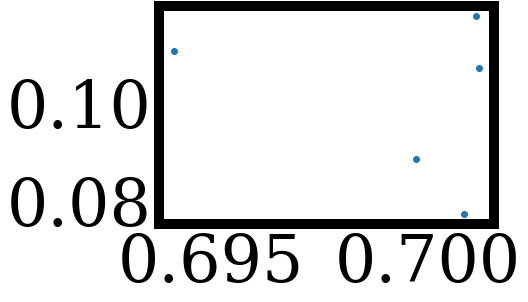

In [ ]:
fede_list = [float(mnu_006_dict['fEDE']), float(mnu_012_dict['fEDE']) ,float(mnu_018_dict['fEDE']),float(mnu_024_dict['fEDE']),float(mnu_03_dict['fEDE'])]
plt.scatter([h_EDE_pp,h_EDE_mnu012,h_EDE_mnu018,h_EDE_mnu024,h_EDE_mnu03],fede_list)

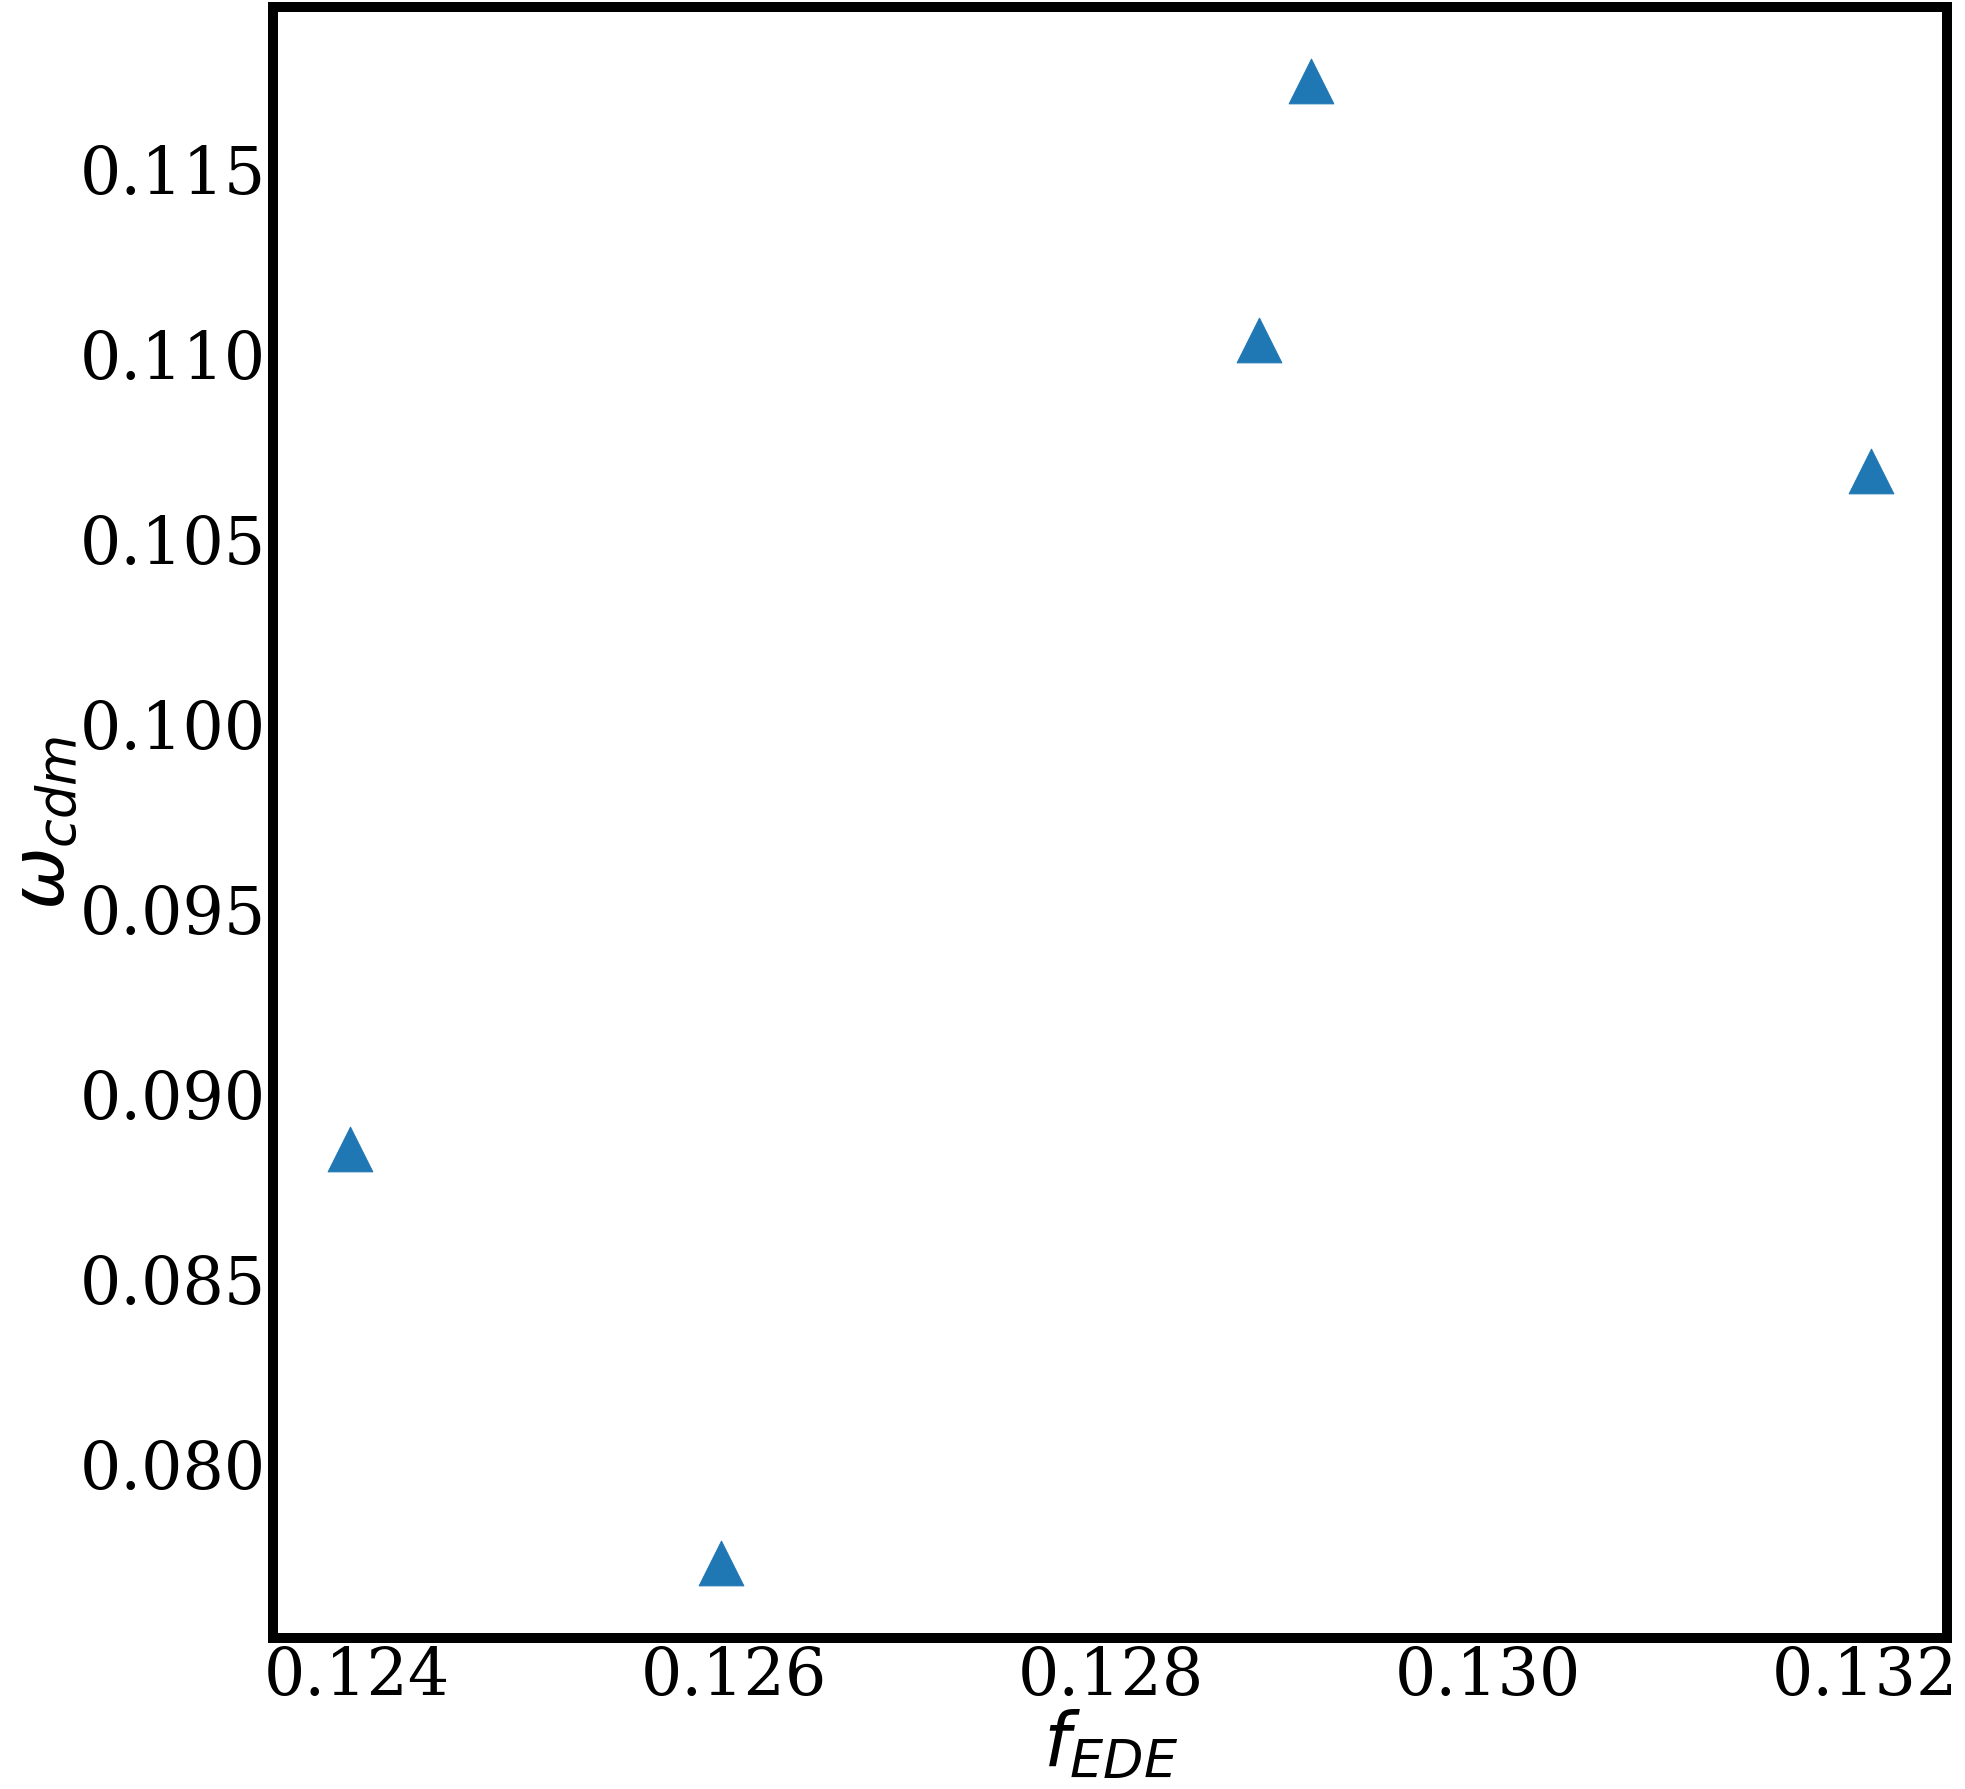

In [ ]:
fig,ax = plt.subplots(figsize=(30,30))

ax.scatter([0.1259341, 0.1239618, 0.132035, 0.1290607, 0.1287868], fede_list,s=2000, marker='^')

ax.set_xlabel(r'$f_{EDE}$')
ax.set_ylabel(r'$\omega_{cdm}$')

fig.savefig('omega_cdm_fede.png', bbox_inches='tight')

[0.07730555, 0.08851186, 0.1068427, 0.1173777, 0.110369]


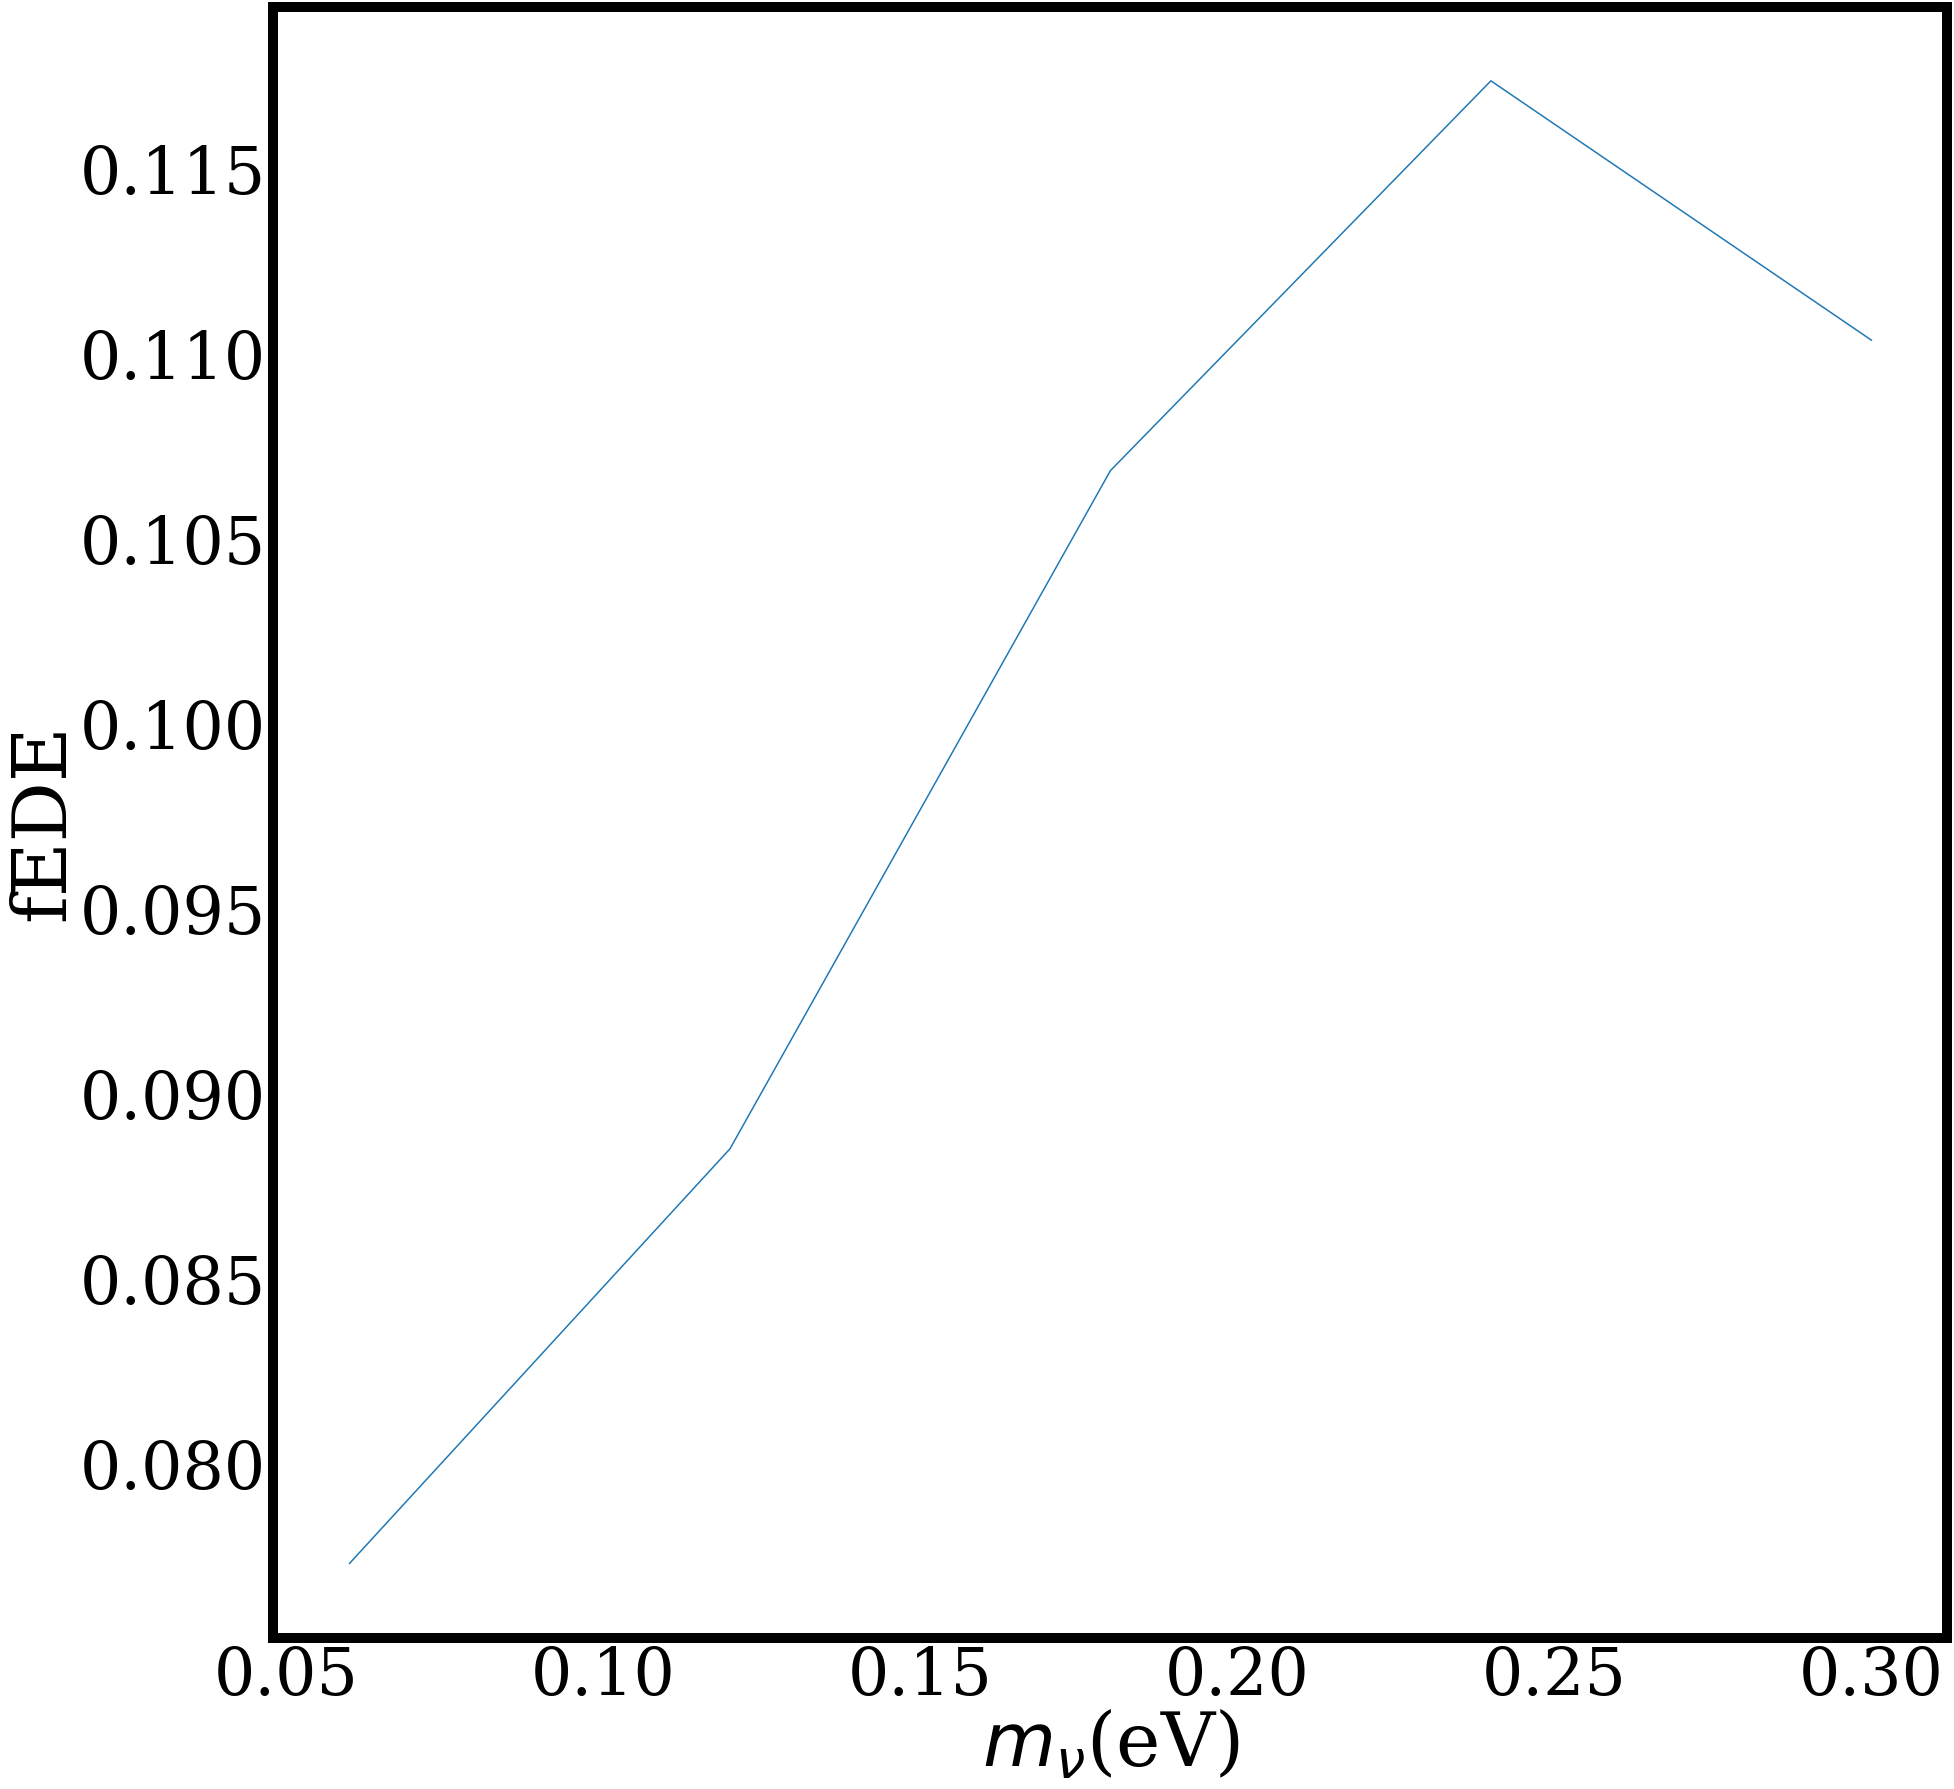

In [ ]:
trend_plot('fEDE')

[0.1271284, 0.1282675, 0.1302535, 0.1313341, 0.1304425]


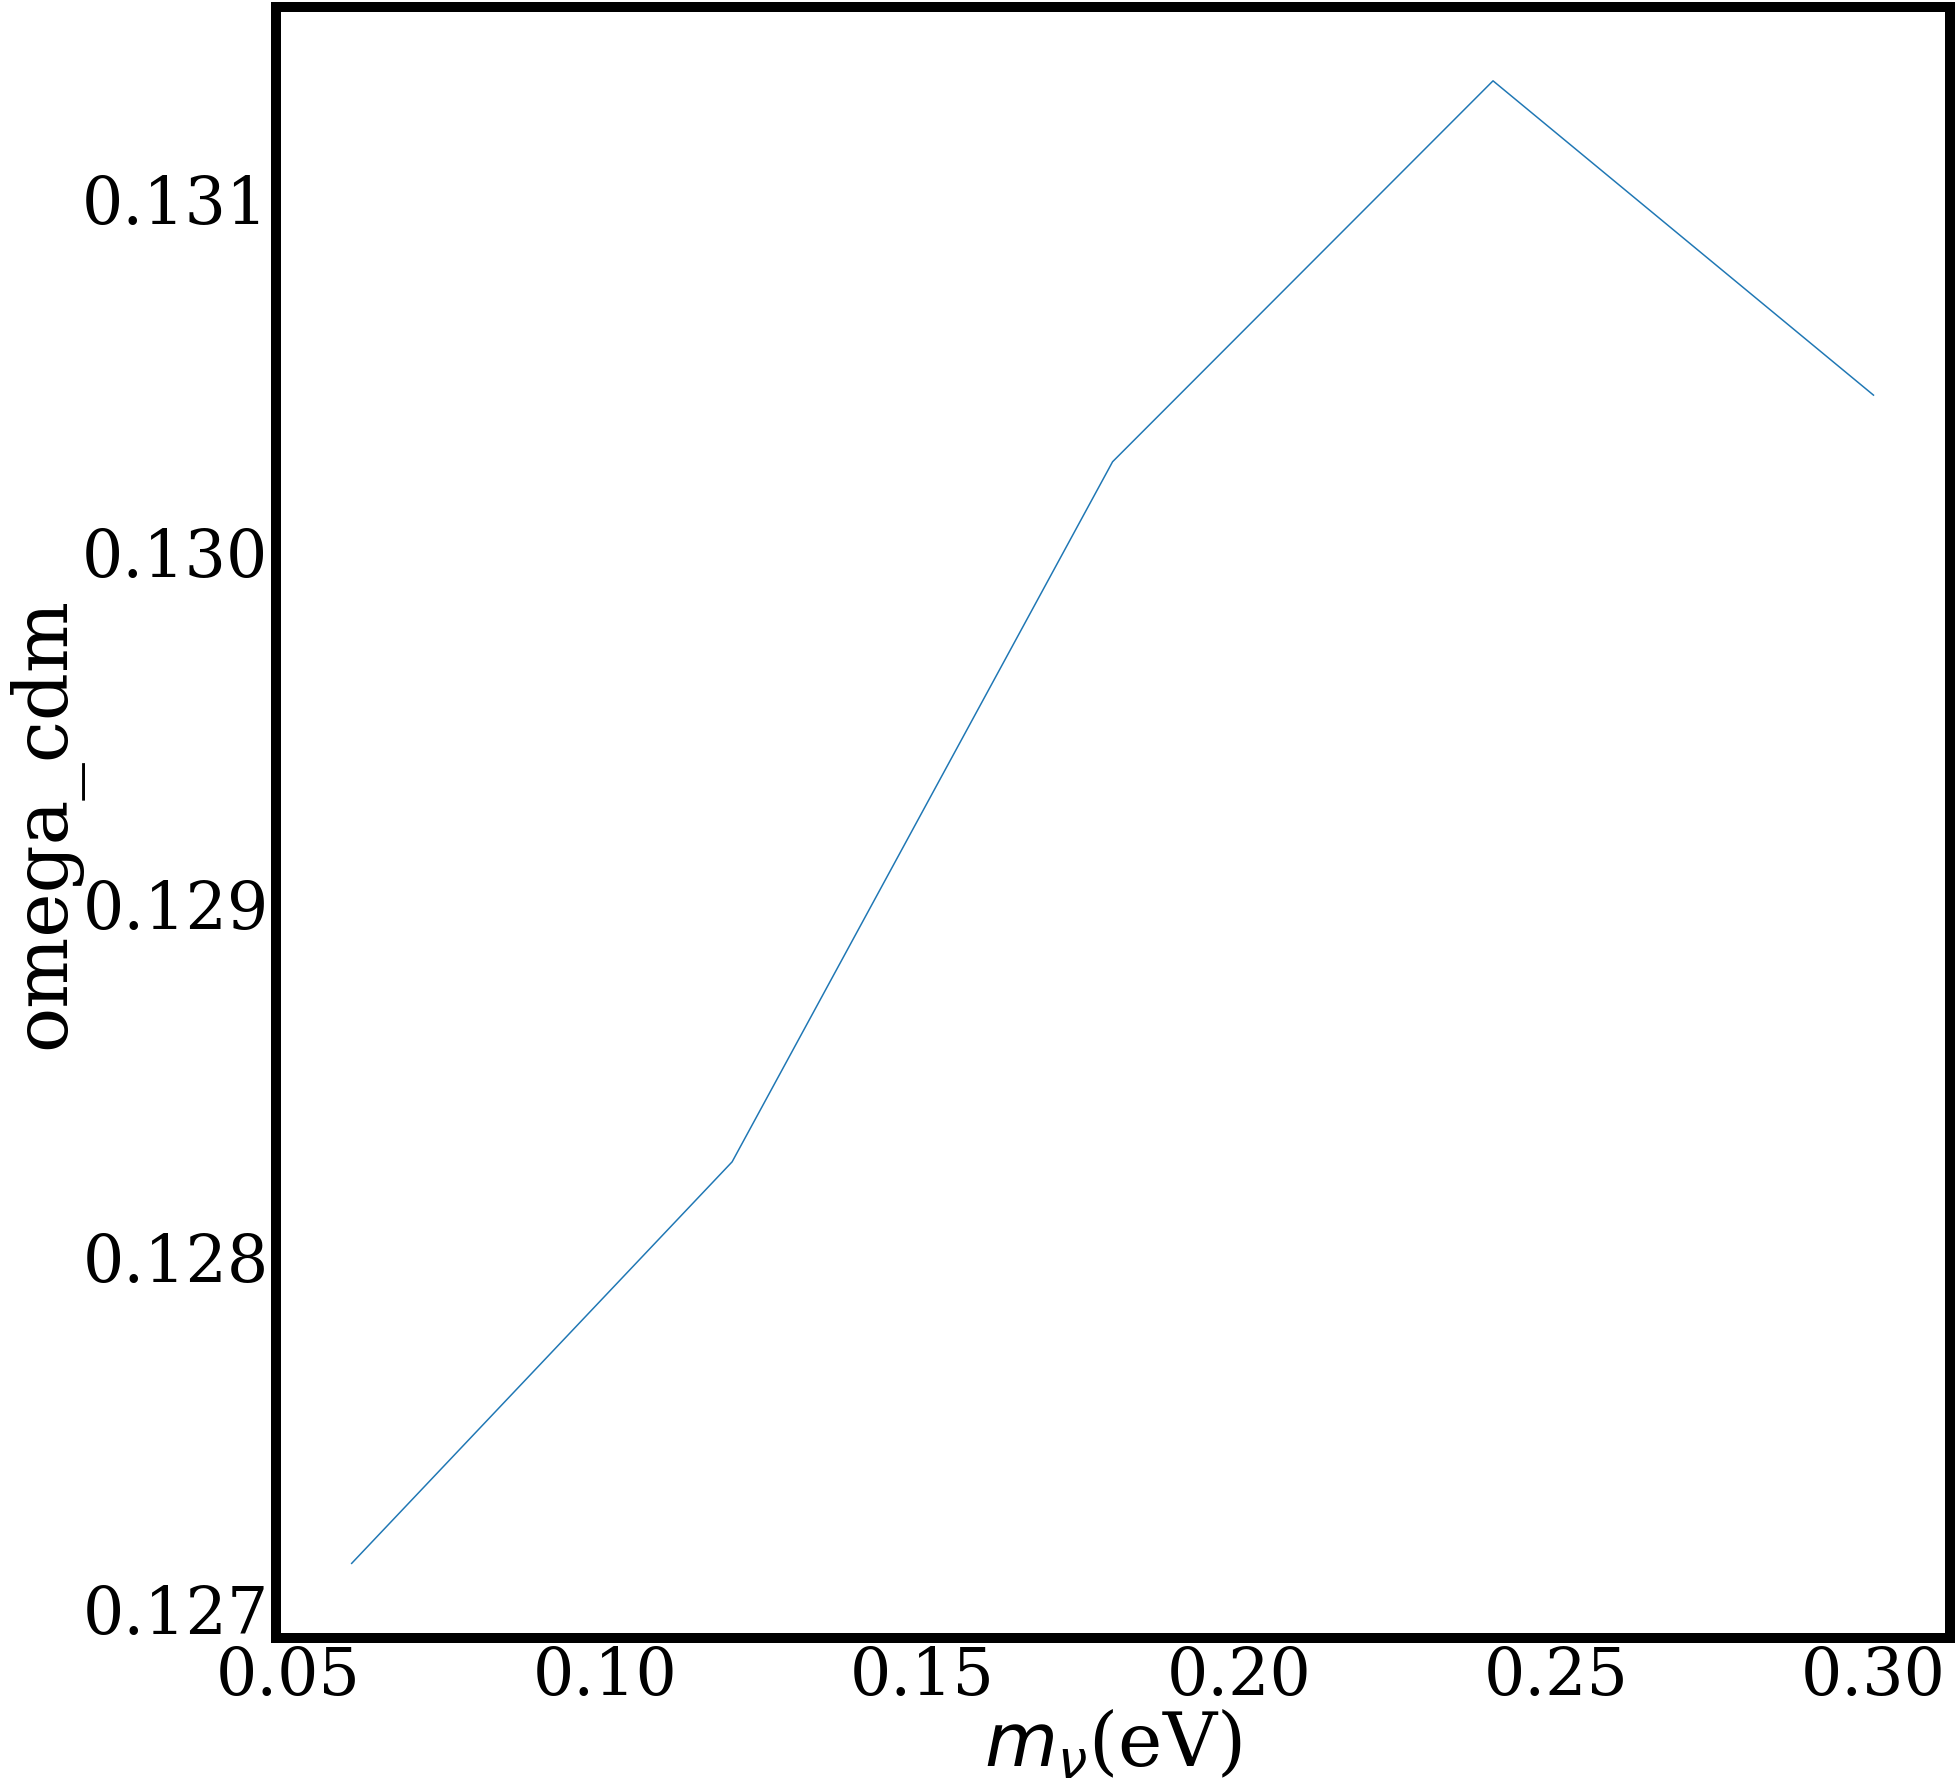

In [ ]:
trend_plot('omega_cdm')

[3.058196, 3.066291, 3.070905, 3.074796, 3.074546]


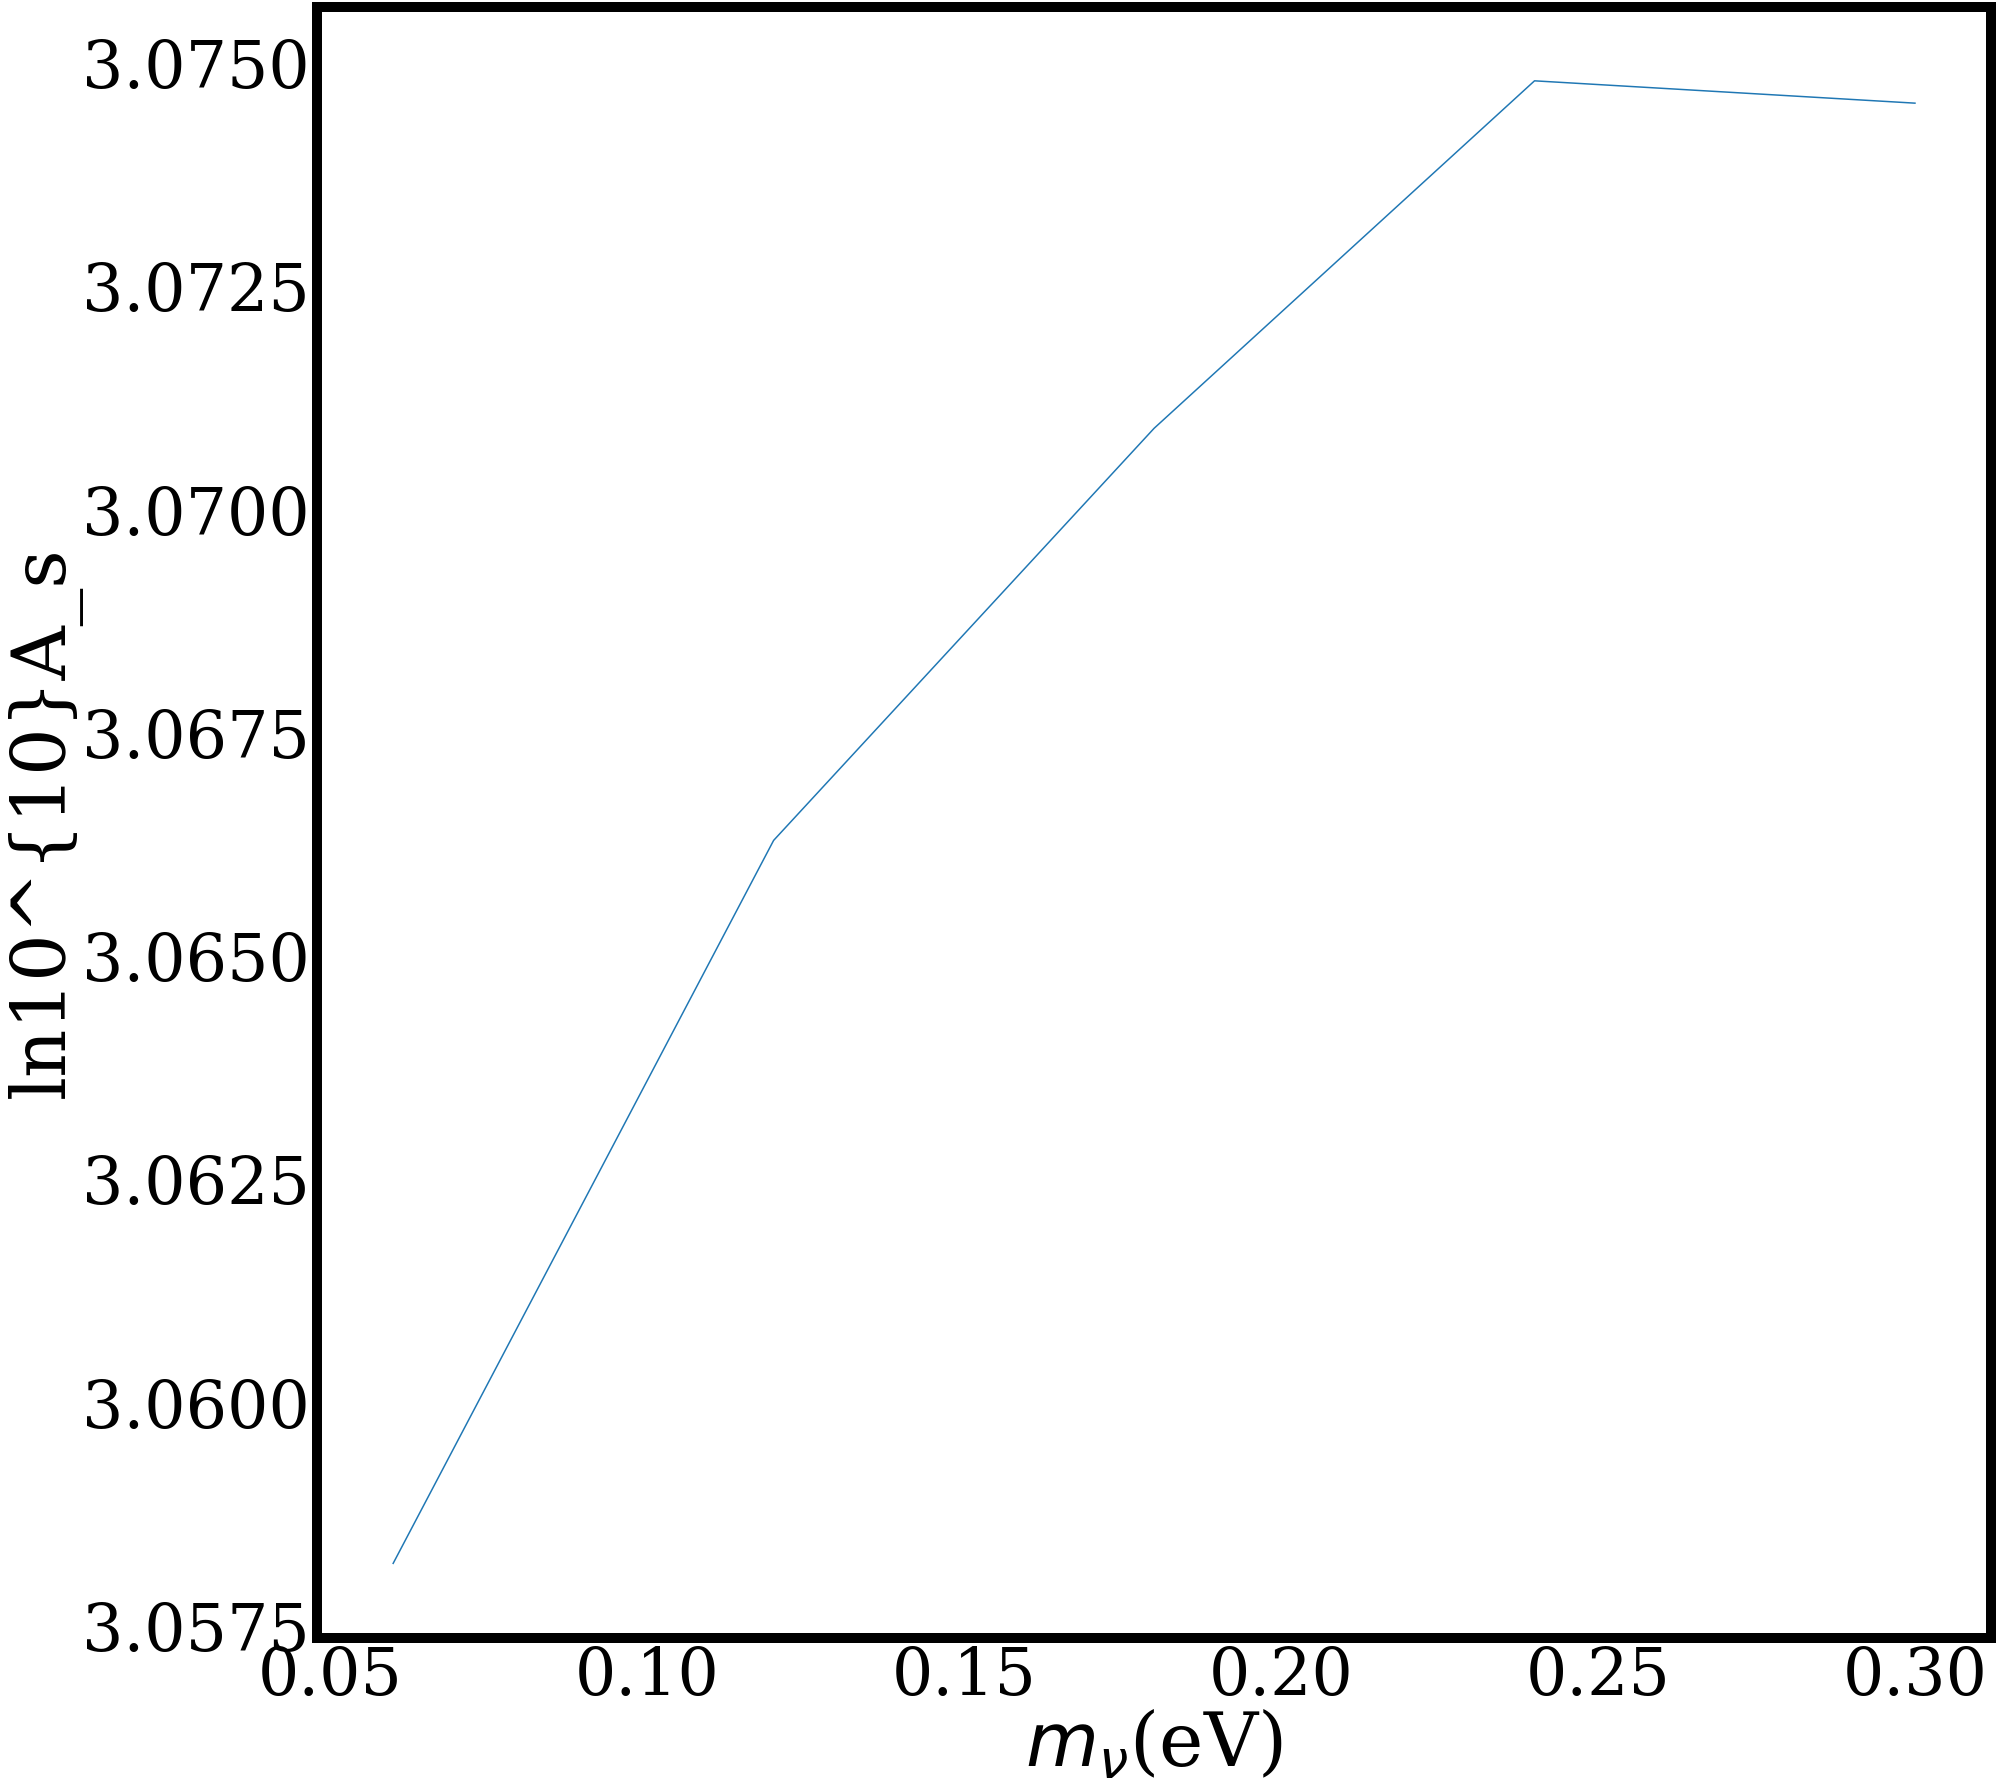

In [ ]:
trend_plot('ln10^{10}A_s')

[1.041436, 1.041473, 1.041364, 1.041332, 1.041413]


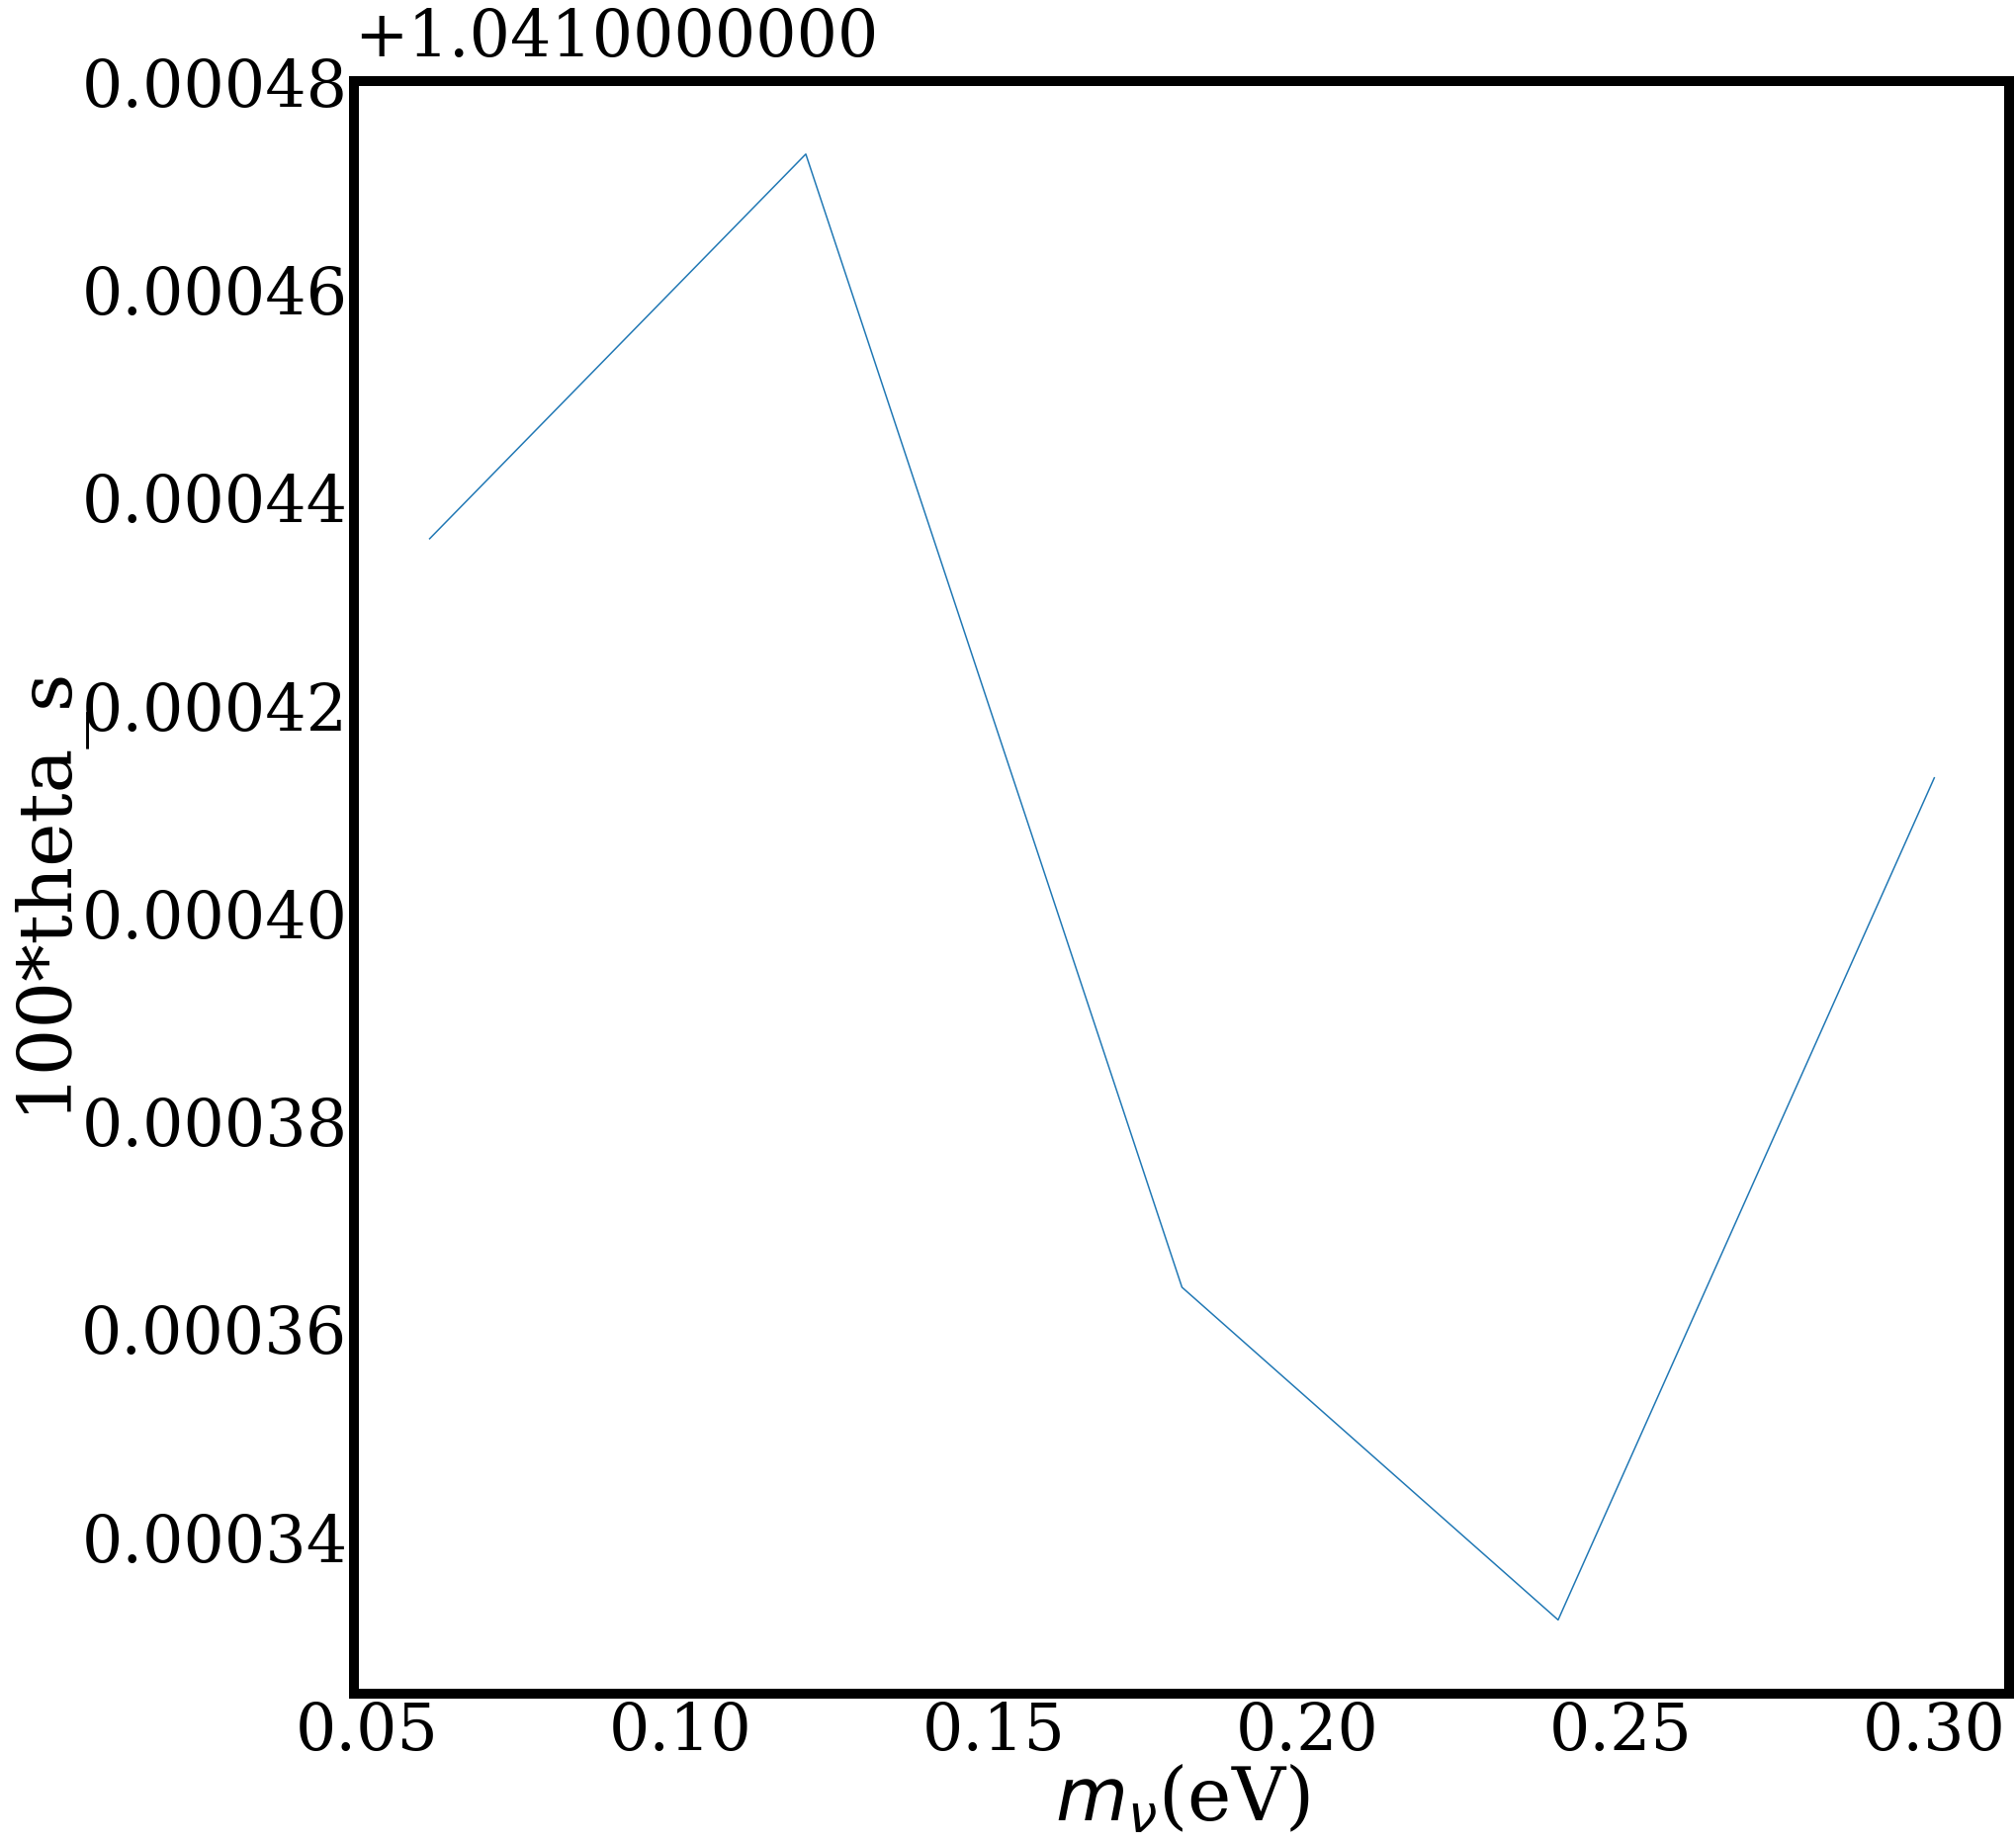

In [ ]:
trend_plot('100*theta_s')

In [ ]:
class_objs = [EDE_pp, EDE_mnu012, EDE_mnu018, EDE_mnu024, EDE_mnu03]

In [ ]:
omega_m_list = []
for class_obj in class_objs:
    omega_m_list.append(class_obj.Omega_m())

print(omega_m_list)

[0.30617235534568565, 0.3107908868193742, 0.314874716244678, 0.3185796398933936, 0.32450203762969837]


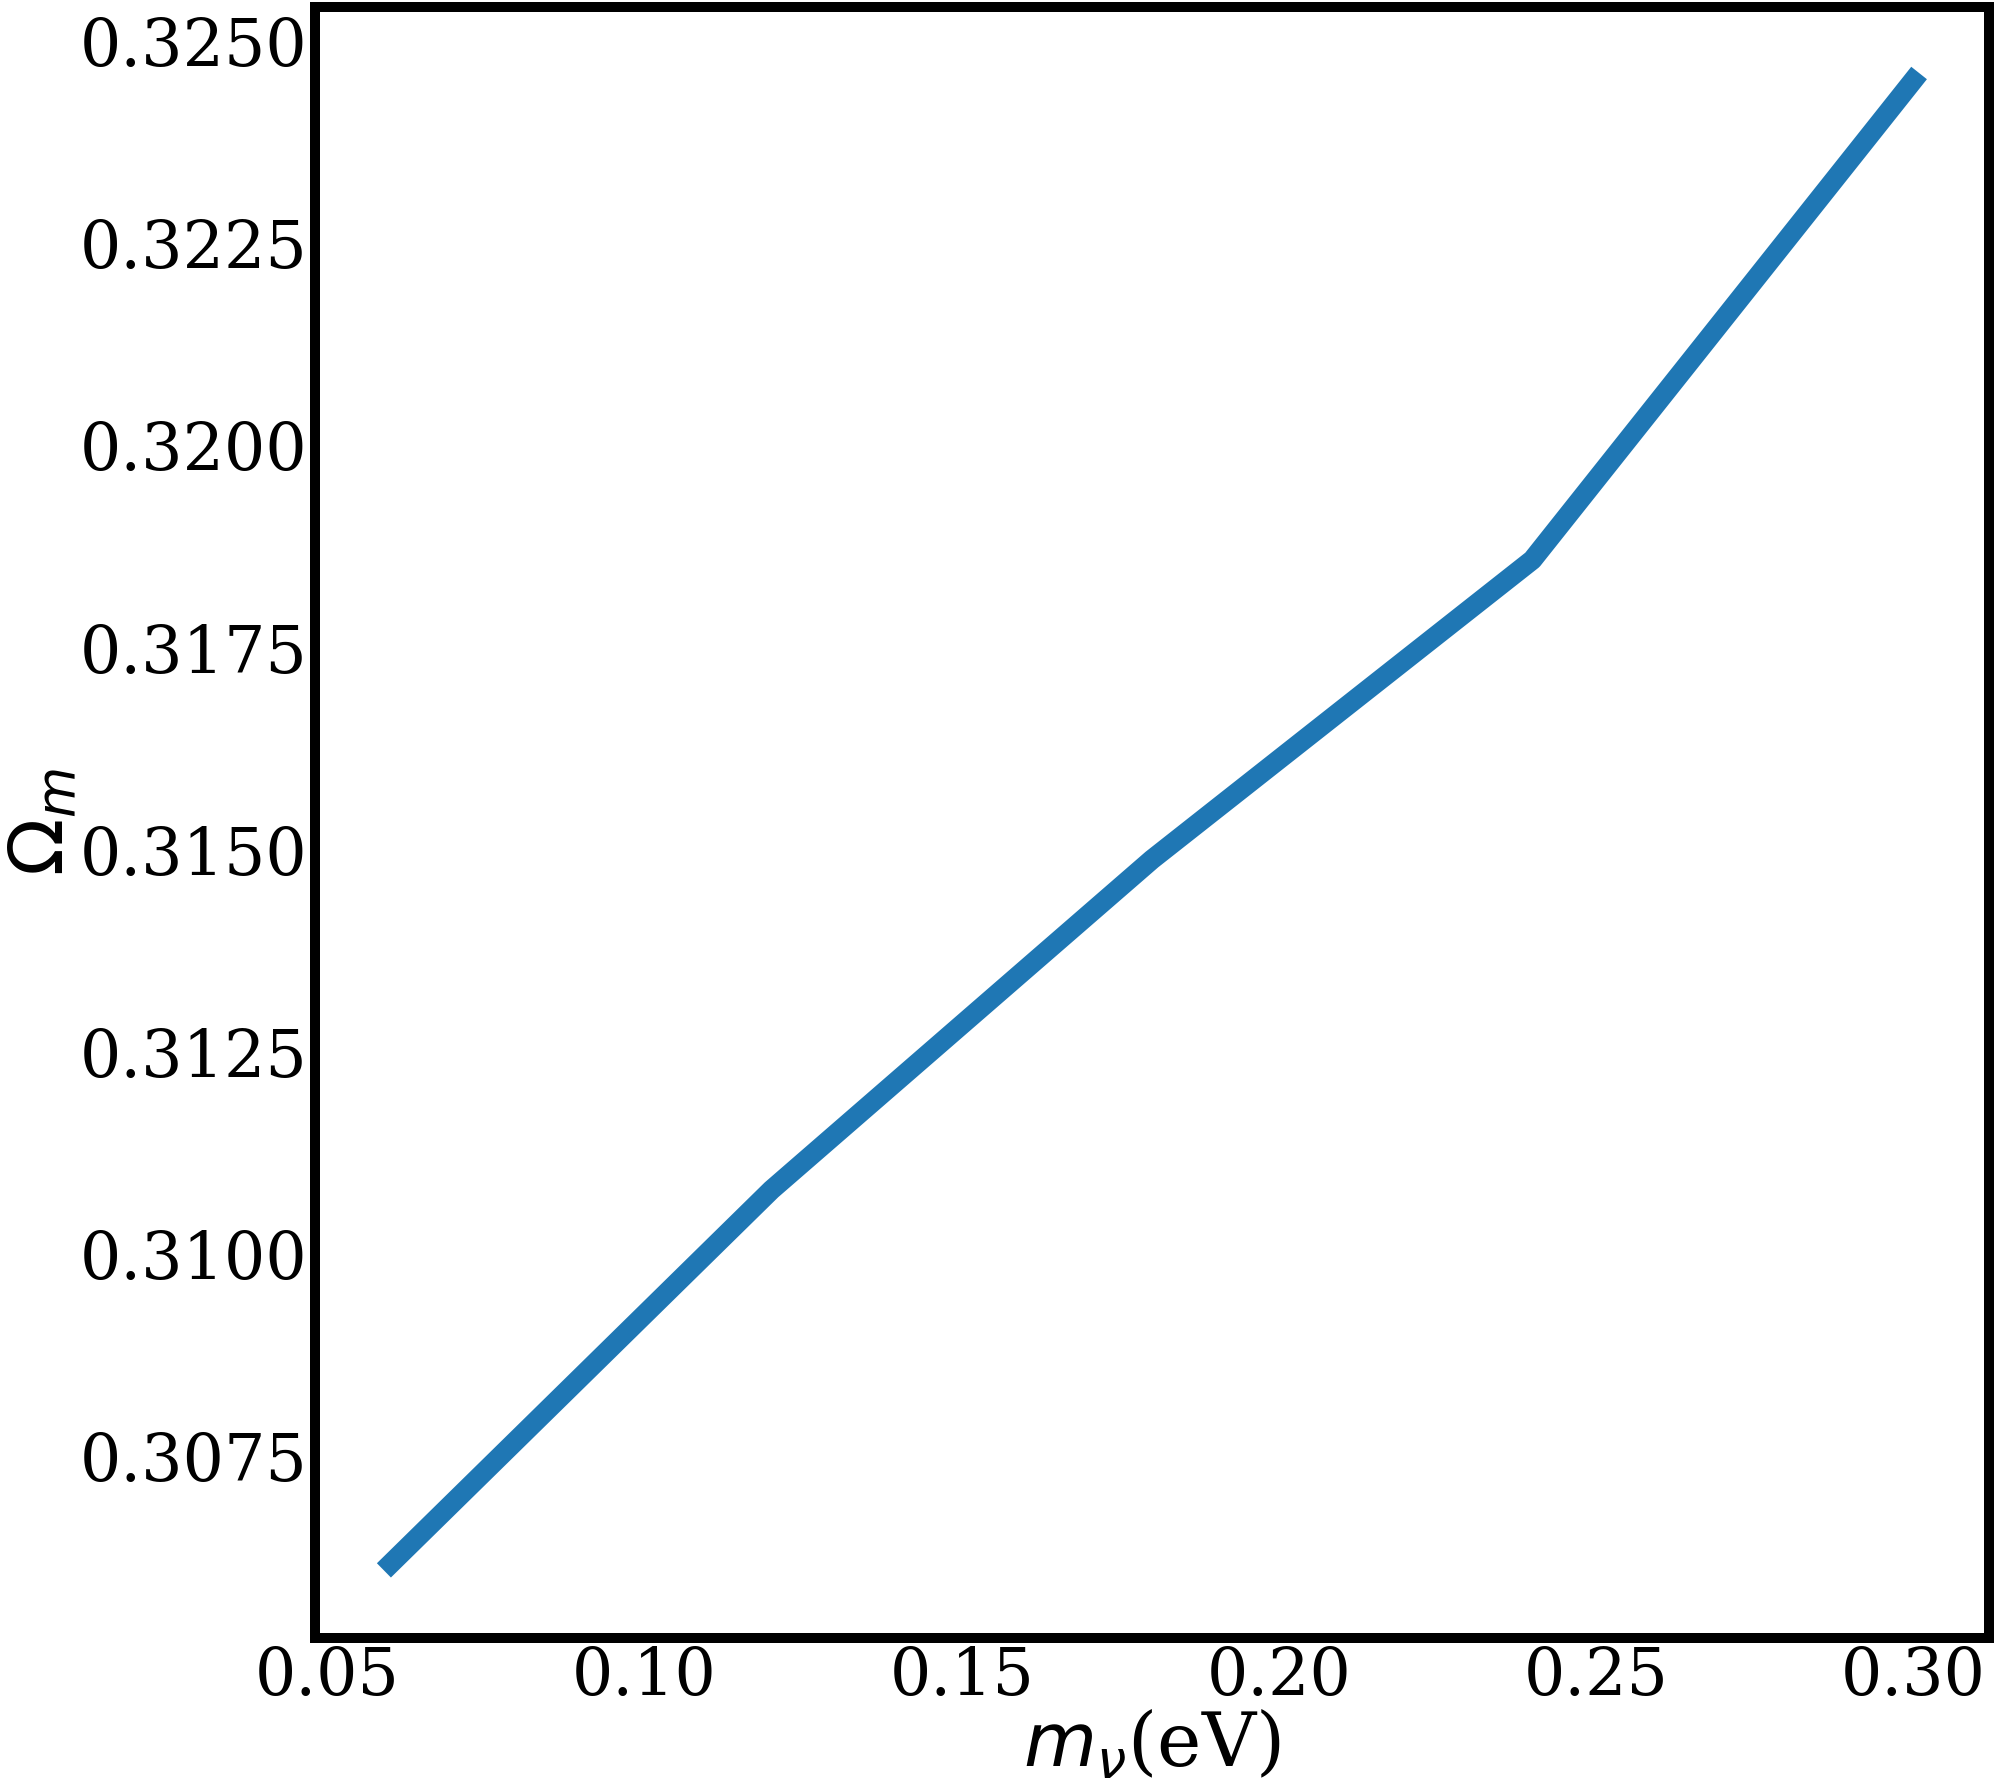

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
x_axis = np.array([0.06,0.12,0.18,0.24,0.30])
ax.plot(x_axis,omega_m_list, lw=20)


ax.set_xlabel(r'$m_\nu$(eV)')
ax.set_ylabel(r'$\Omega_m$')

fig.savefig('omega_m_plot.pdf', bbox_inches='tight')

In [ ]:
omega_cdm_list = []
for class_obj in class_objs:
    omega_cdm_list.append(class_obj.Omega0_cdm())
    print(class_obj.Omega0_cdm())

print(omega_cdm_list)

0.258841965036291
0.2619789018706484
0.264945848759149
0.26719722251937494
0.2707047901481443
[0.258841965036291, 0.2619789018706484, 0.264945848759149, 0.26719722251937494, 0.2707047901481443]


Text(0, 0.5, '$\\Omega_{cdm}$')

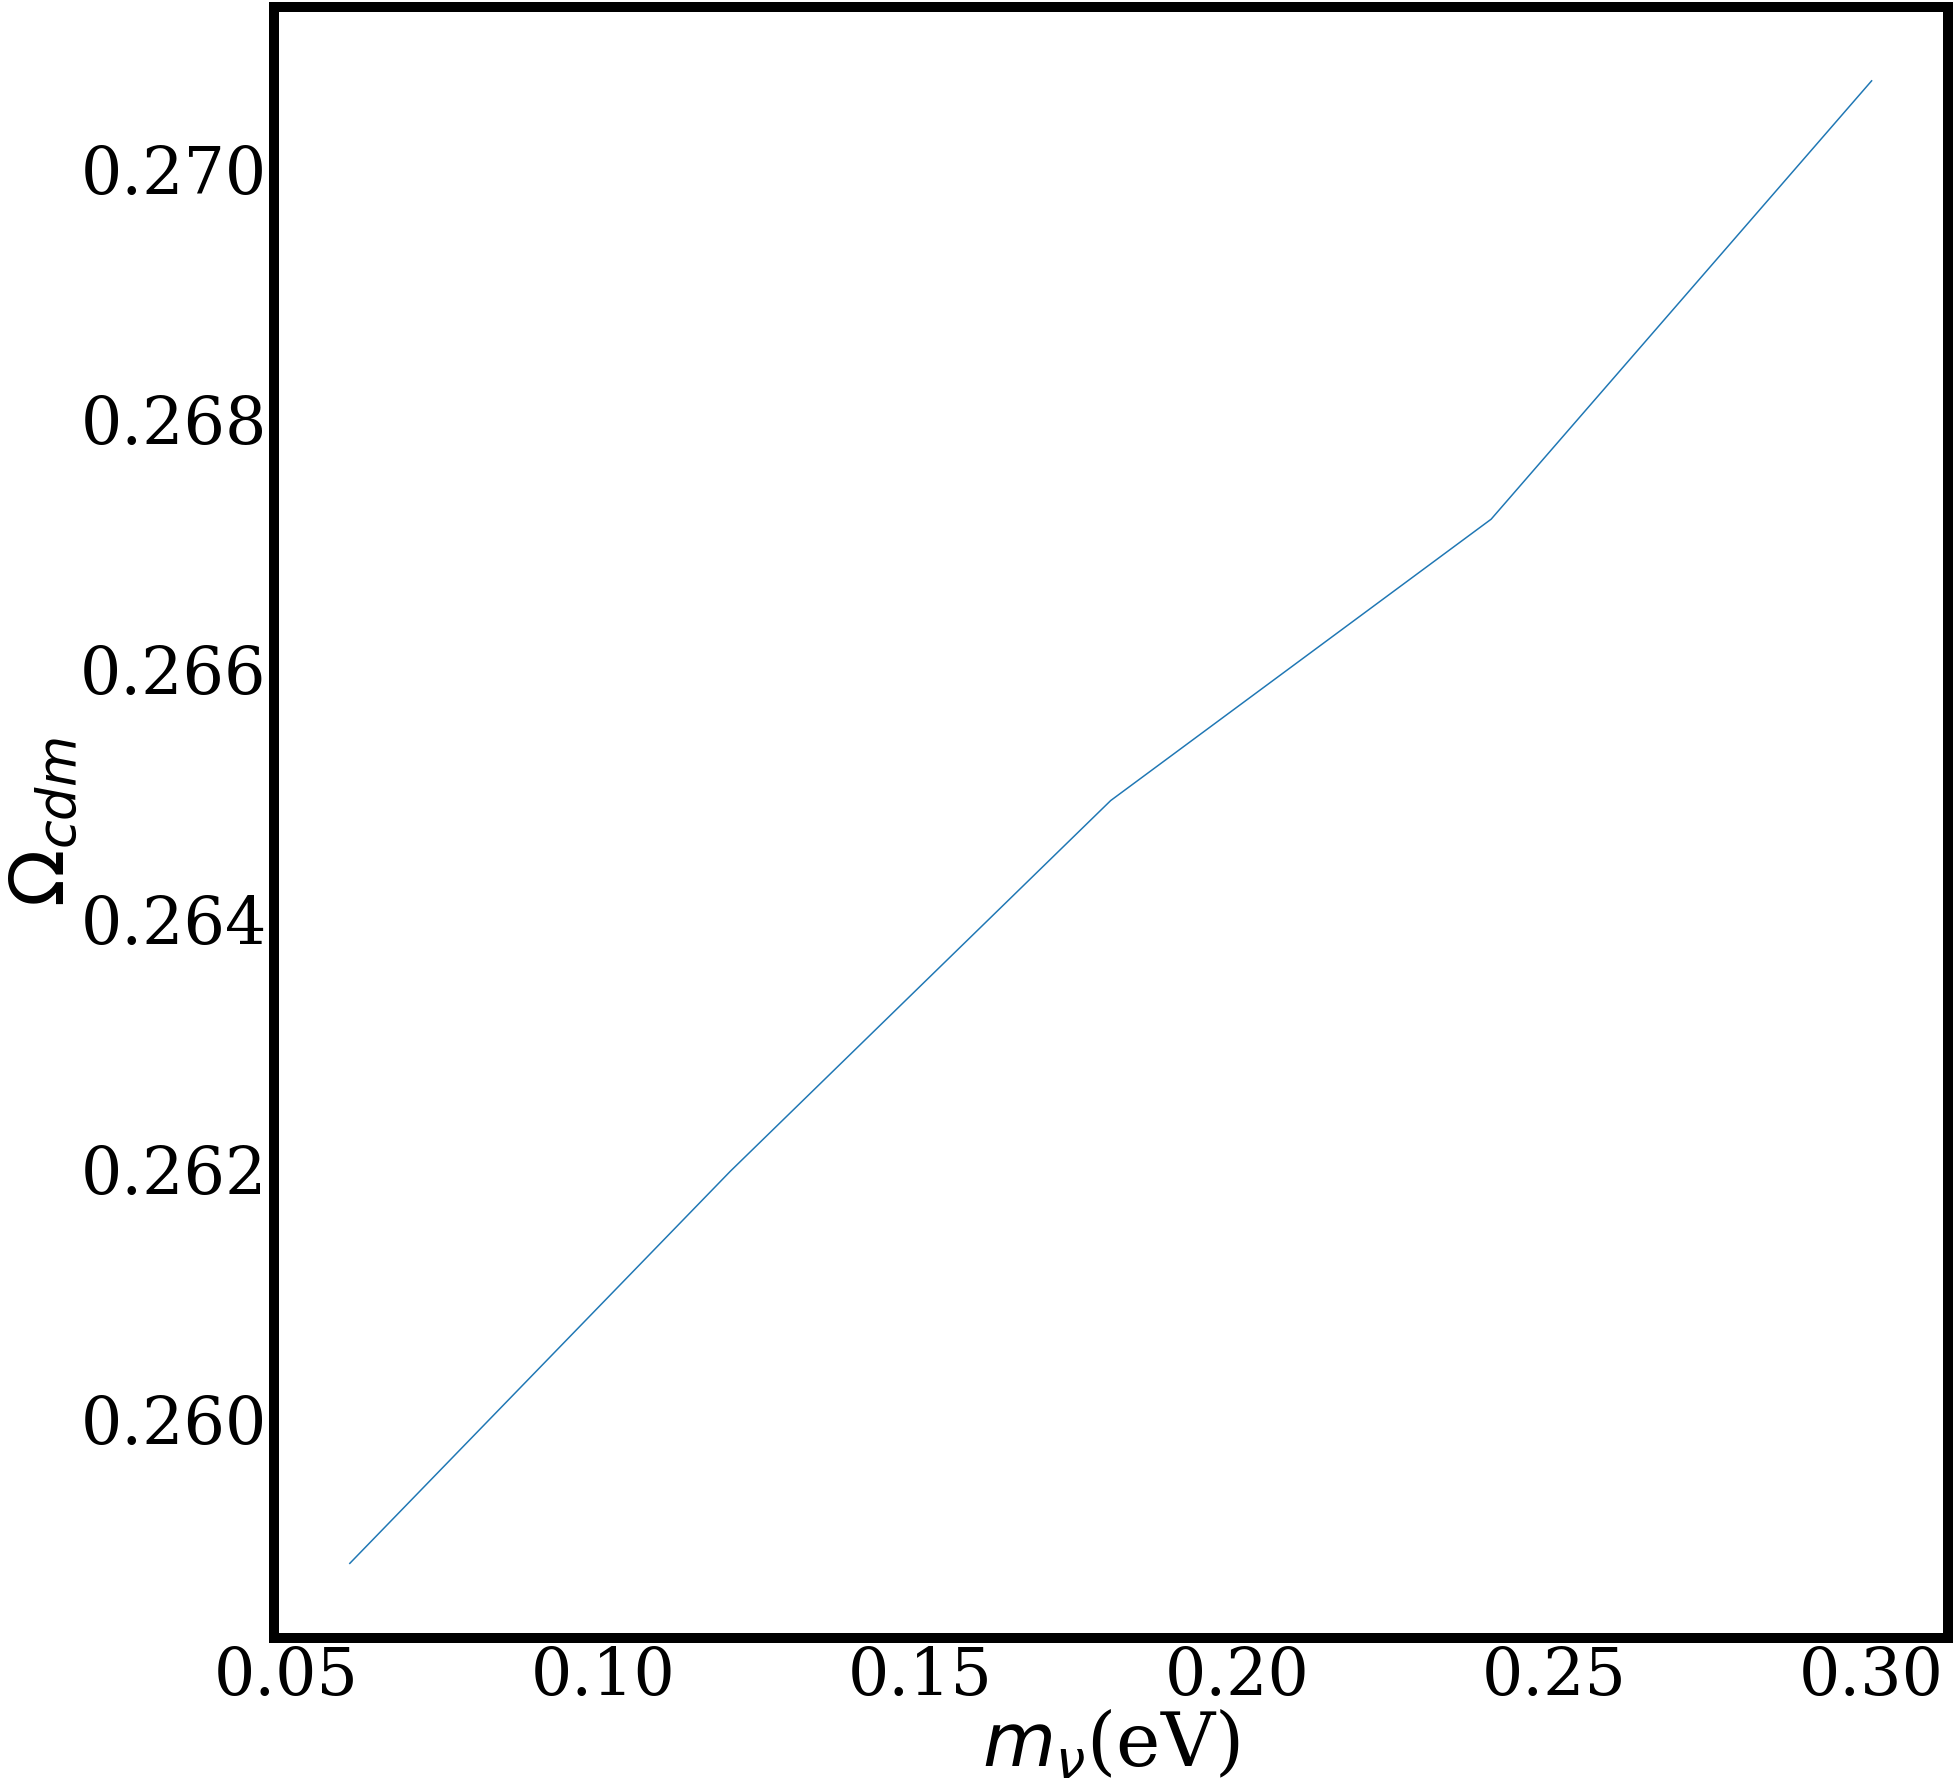

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
x_axis = np.array([0.06,0.12,0.18,0.24,0.30])
ax.plot(x_axis,omega_cdm_list )


ax.set_xlabel(r'$m_\nu$(eV)')
ax.set_ylabel(r'$\Omega_{cdm}$')

In [ ]:
a_fac_list = []

for class_obj in class_objs:
    a_fac_list.append(2*(1/(class_obj.h()*100*np.sqrt(class_obj.Omega_m()))))

Text(0, 0.5, 'A factor')

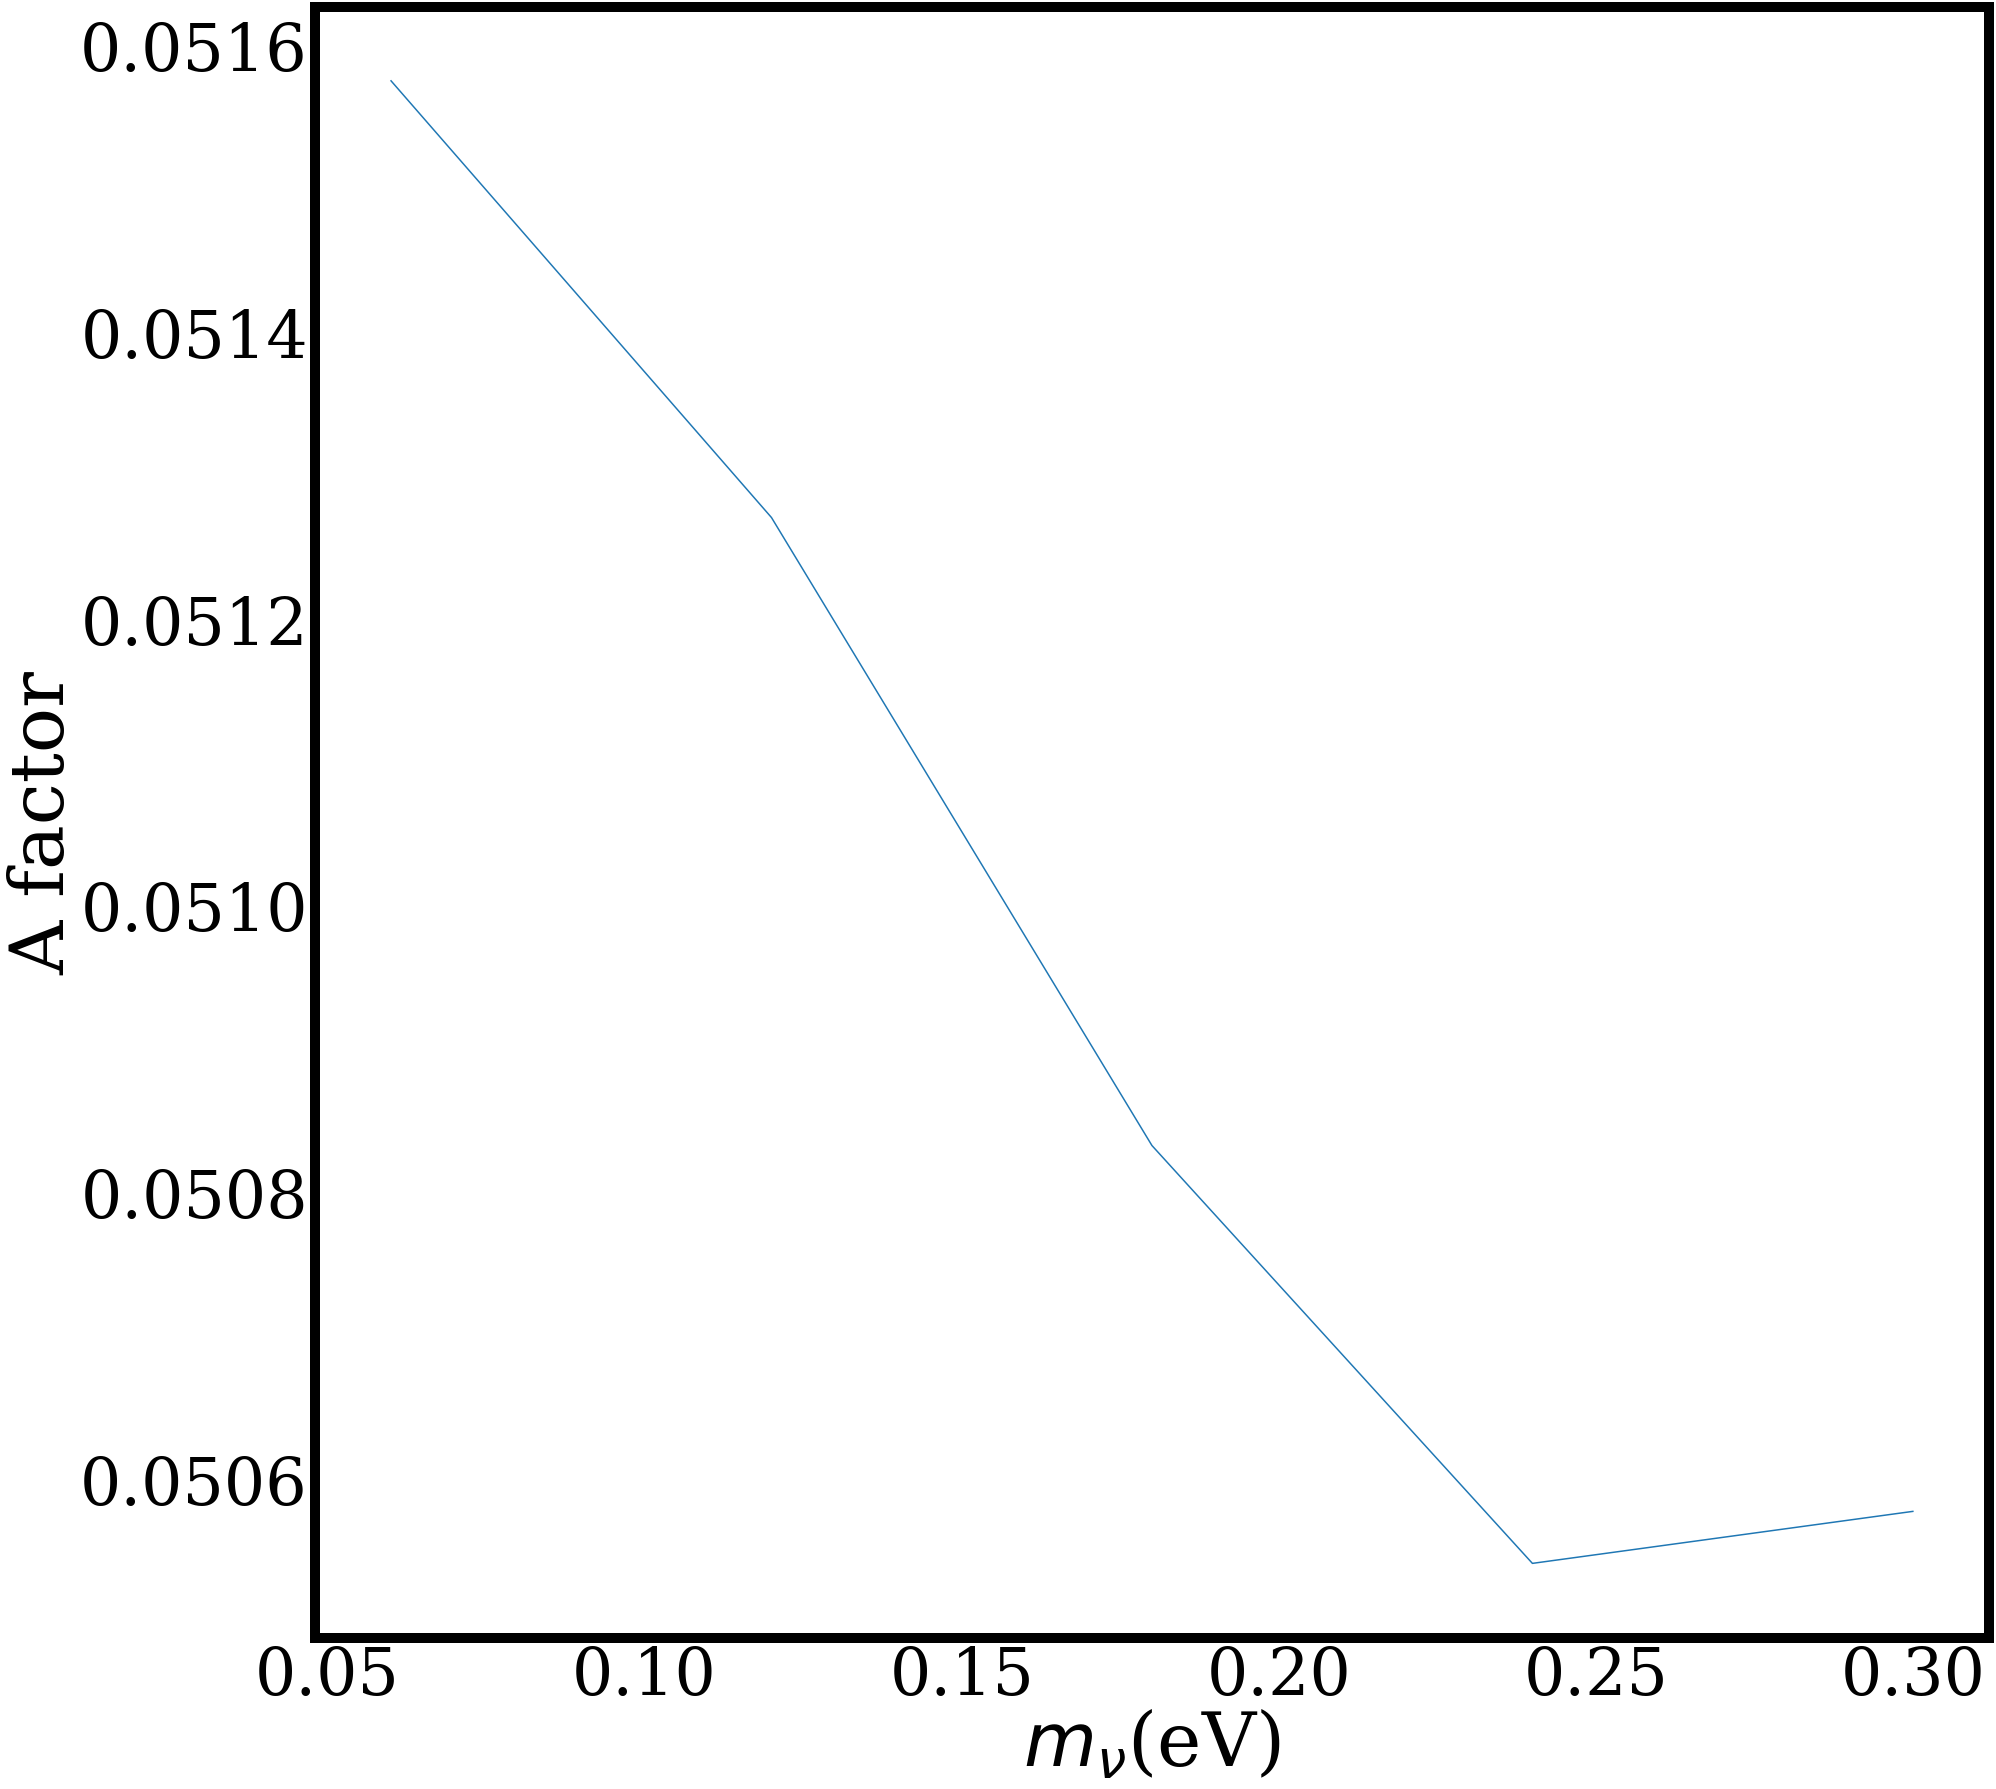

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
x_axis = np.array([0.06,0.12,0.18,0.24,0.30])
ax.plot(x_axis,a_fac_list)


ax.set_xlabel(r'$m_\nu$(eV)')
ax.set_ylabel(r'A factor')

In [ ]:
for class_obj in class_objs:
    print((class_obj.h()*100*np.sqrt(class_obj.Omega_m())))

38.778136413543486
39.008503917345124
39.34459107769688
39.57143412285266
39.543062445826024
